In [1]:
import os
import json
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rc('font', size=16)

In [3]:
DYNAMICS_TRAINING_FILES = {
    "model_loss_history"                   : "model_loss_history.txt",
    "model_pol_total_loss_history"         : "model_pol_total_loss_history.txt",
    "model_pol_var_loss_history"           : "model_pol_var_loss_history.txt",
    "model_mean_pol_loss_history"          : "model_mean_pol_loss_history.txt",
    "model_holdout_loss_history"           : "model_holdout_loss_history.txt",
    "model_holdout_pol_total_loss_history" : "model_holdout_pol_total_loss_history.txt",
    "model_holdout_pol_var_loss_history"   : "model_holdout_pol_var_loss_history.txt",
    "model_holdout_mean_pol_loss_history"  : "model_holdout_mean_pol_loss_history.txt",
}
SAC_TRAINING_FILES = {
    "result": "result.json"
}
DynamicsTrainingResults = namedtuple('DynamicsTrainingResults', DYNAMICS_TRAINING_FILES.keys())
SacTrainingResults = namedtuple('DynamicsTrainingResults', SAC_TRAINING_FILES.keys())
ExperimentResults = namedtuple('ExperimentRecord', 'name base_dir experiment_dir environment dataset params seed rex rex_beta holdout_policy dynamics sac')

In [4]:
MOPO_RESULTS_MAP_PATH = "../dogo_results/mopo/results_map.json"

RESULTS_BASEDIR = "../dogo_results/mopo"
get_results_path = lambda x: os.path.join(RESULTS_BASEDIR, x) if os.path.isfile(os.path.join(RESULTS_BASEDIR, x)) else x

In [5]:
def get_results(experiment: str):
    with open(MOPO_RESULTS_MAP_PATH, 'r') as f:
        mopo_results_map = json.load(f)

    environment = mopo_results_map[experiment]["environment"]
    base_dir = mopo_results_map[experiment]["base_dir"]
    experiment_dir = mopo_results_map[experiment]["experiment_dir"]

    results_dir = os.path.join("ray_mopo", environment, base_dir, experiment_dir)
    repo_results_dir = os.path.join(RESULTS_BASEDIR, results_dir)
    if os.path.isdir(repo_results_dir):
        results_dir = repo_results_dir

    with open(os.path.join(results_dir, "params.json"), 'r') as f:
        params = json.load(f)
    
    dynamics_training_results = {}
    for k, v in DYNAMICS_TRAINING_FILES.items():
        file_path = os.path.join(results_dir, v)
        dynamics_training_results[k] = pd.read_csv(file_path, header=None)
    dynamics_training_results = DynamicsTrainingResults(**dynamics_training_results)

    sac_training_results = {}
    for k, v in SAC_TRAINING_FILES.items():
        file_path = os.path.join(results_dir, v)
        sac_training_results[k] = pd.read_json(file_path, lines=True)
    sac_training_results = SacTrainingResults(**sac_training_results)

    return ExperimentResults(
        name = experiment,
        base_dir = base_dir,
        experiment_dir = experiment_dir,
        environment = environment,
        dataset = params["algorithm_params"]["kwargs"]["pool_load_path"].split("/")[-1][:-4],
        params=params,
        seed = params["run_params"]["seed"],
        rex = params["algorithm_params"]["kwargs"].get("rex", False),
        rex_beta = params["algorithm_params"]["kwargs"].get("rex_beta", None),
        holdout_policy = params["algorithm_params"]["kwargs"].get("holdout_policy", None),
        dynamics = dynamics_training_results,
        sac = sac_training_results
    )

# MP068-MP069, MP072-MP073, MP078

In [6]:
MP068 = get_results("MP068")
MP069 = get_results("MP069")
MP072 = get_results("MP072")
MP073 = get_results("MP073")
MP078 = get_results("MP078")

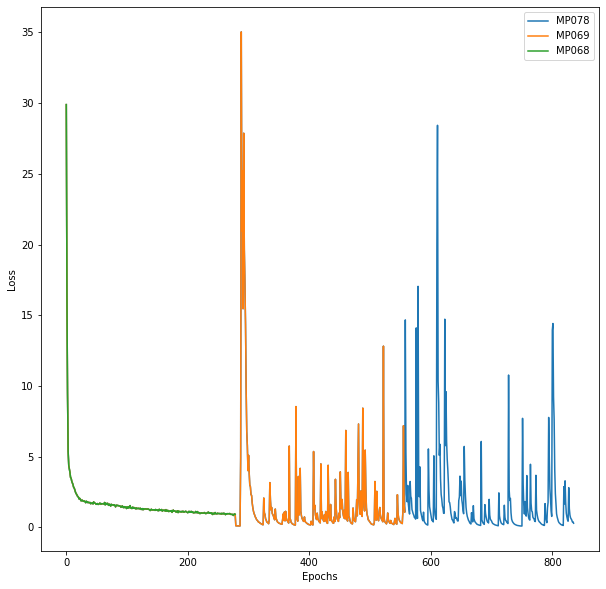

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP078.dynamics.model_loss_history.mean(axis=1), label='MP078')
ax.plot(MP069.dynamics.model_loss_history.mean(axis=1), label='MP069')
ax.plot(MP068.dynamics.model_loss_history.mean(axis=1), label='MP068')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

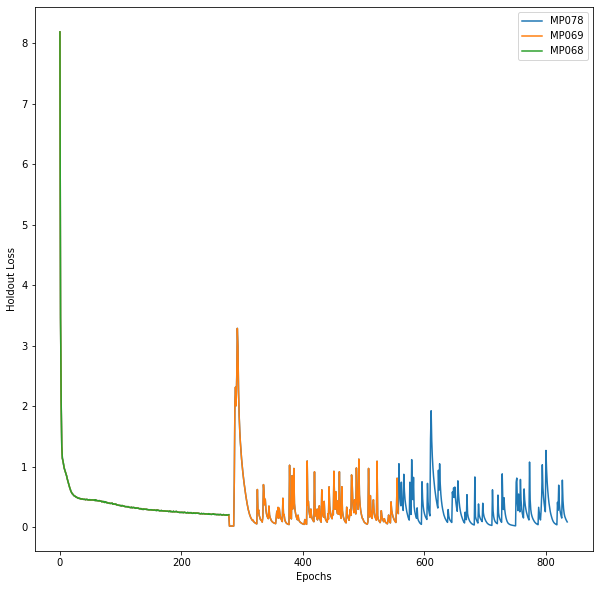

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP078.dynamics.model_holdout_loss_history.mean(axis=1), label='MP078')
ax.plot(MP069.dynamics.model_holdout_loss_history.mean(axis=1), label='MP069')
ax.plot(MP068.dynamics.model_holdout_loss_history.mean(axis=1), label='MP068')
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

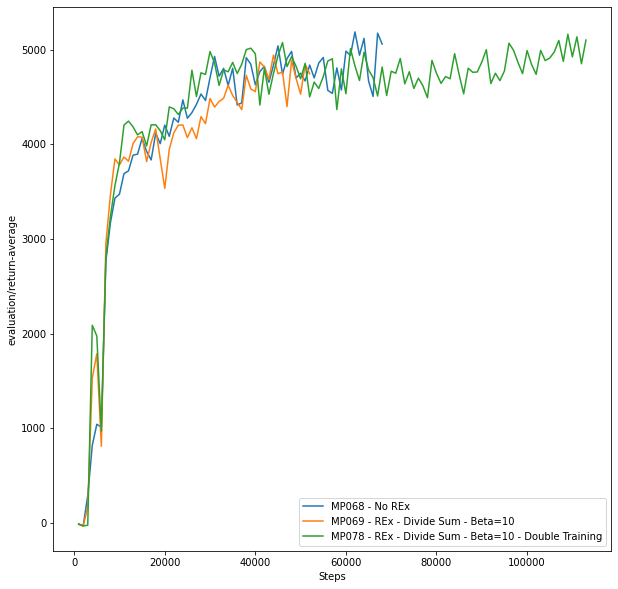

In [9]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP068.sac.result['timesteps_total'], MP068.sac.result[feature], label='MP068 - No REx')
ax.plot(MP069.sac.result['timesteps_total'], MP069.sac.result[feature], label='MP069 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

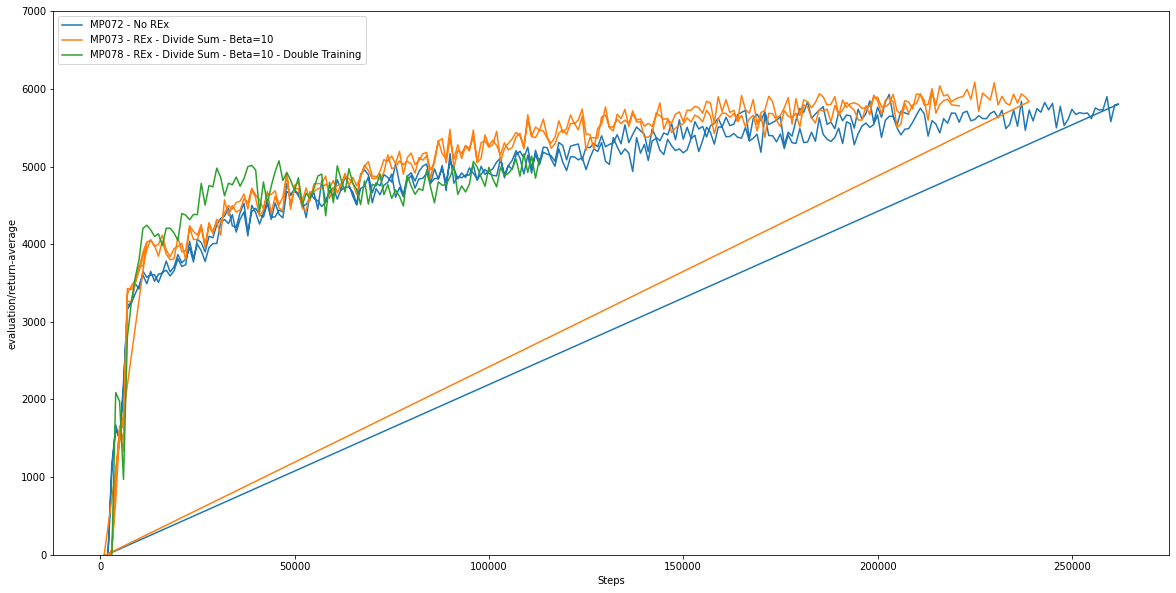

In [10]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
# ax.plot(MP068.sac.result['timesteps_total'], MP068.sac.result[feature], label='MP068 - No REx')
ax.plot(MP072.sac.result['timesteps_total'], MP072.sac.result[feature], label='MP072 - No REx')
# ax.plot(MP069.sac.result['timesteps_total'], MP069.sac.result[feature], label='MP069 - REx - Divide Sum - Beta=10')
ax.plot(MP073.sac.result['timesteps_total'], MP073.sac.result[feature], label='MP073 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.set_ylim(0,7000)
ax.legend(loc='upper left')
pass

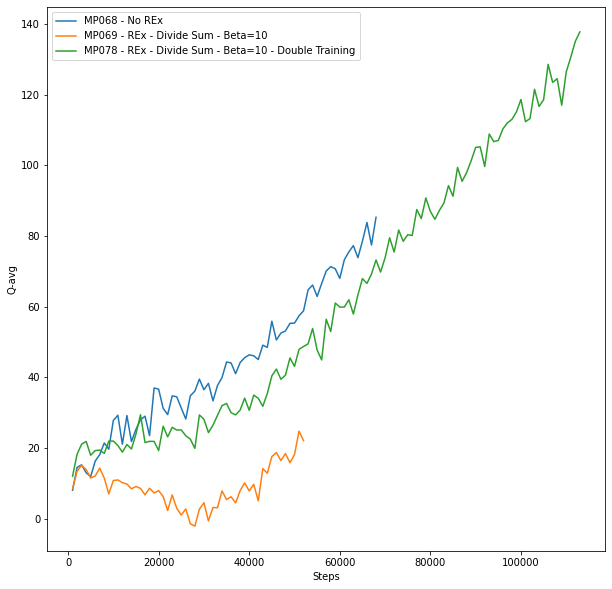

In [11]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP068.sac.result['timesteps_total'], MP068.sac.result[feature], label='MP068 - No REx')
ax.plot(MP069.sac.result['timesteps_total'], MP069.sac.result[feature], label='MP069 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

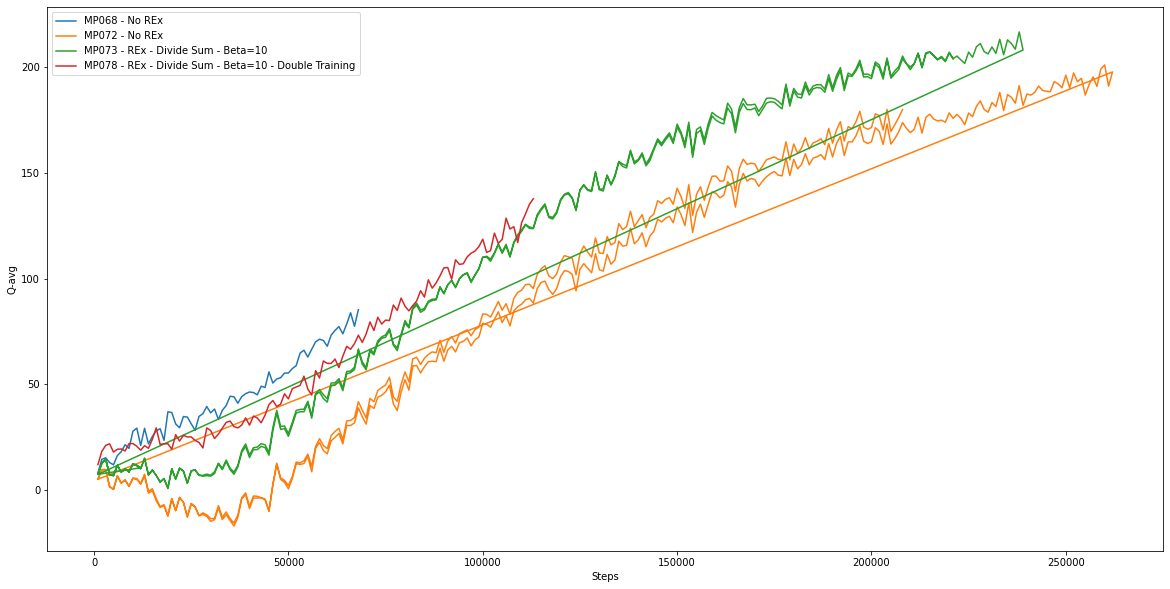

In [12]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP068.sac.result['timesteps_total'], MP068.sac.result[feature], label='MP068 - No REx')
ax.plot(MP072.sac.result['timesteps_total'], MP072.sac.result[feature], label='MP072 - No REx')
ax.plot(MP073.sac.result['timesteps_total'], MP073.sac.result[feature], label='MP073 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

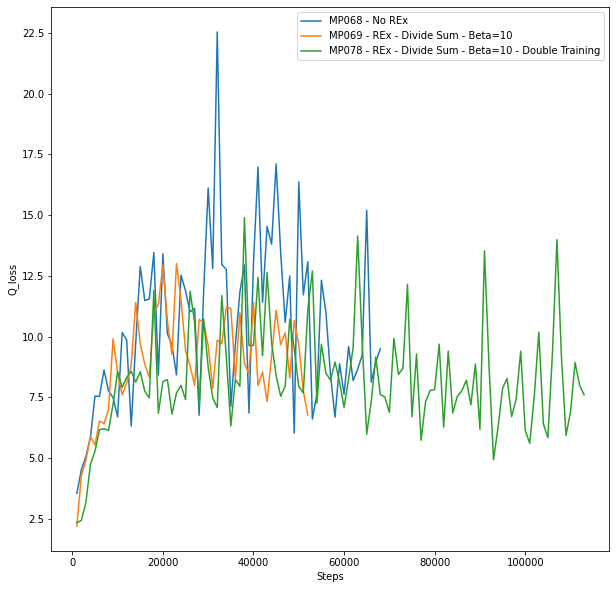

In [13]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP068.sac.result['timesteps_total'], MP068.sac.result[feature], label='MP068 - No REx')
ax.plot(MP069.sac.result['timesteps_total'], MP069.sac.result[feature], label='MP069 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

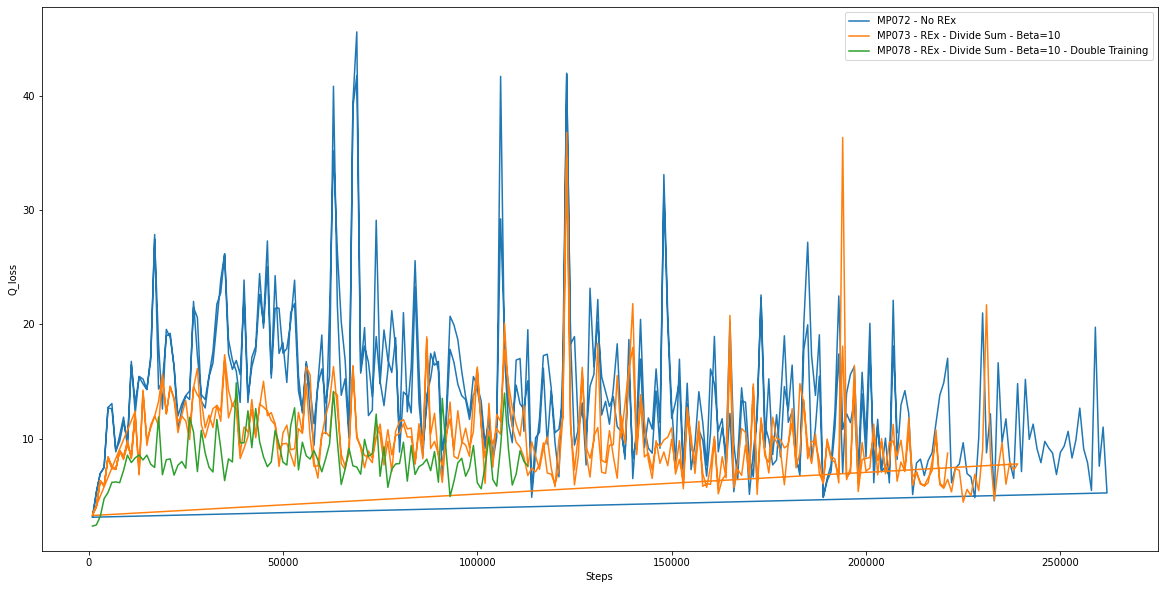

In [14]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP072.sac.result['timesteps_total'], MP072.sac.result[feature], label='MP072 - No REx')
ax.plot(MP073.sac.result['timesteps_total'], MP073.sac.result[feature], label='MP073 - REx - Divide Sum - Beta=10')
ax.plot(MP078.sac.result['timesteps_total'], MP078.sac.result[feature], label='MP078 - REx - Divide Sum - Beta=10 - Double Training')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

# MP070-MP071, MP074-MP075, MP079

In [15]:
MP070 = get_results("MP070")
MP071 = get_results("MP071")
MP074 = get_results("MP074")
MP075 = get_results("MP075")
MP079 = get_results("MP079")

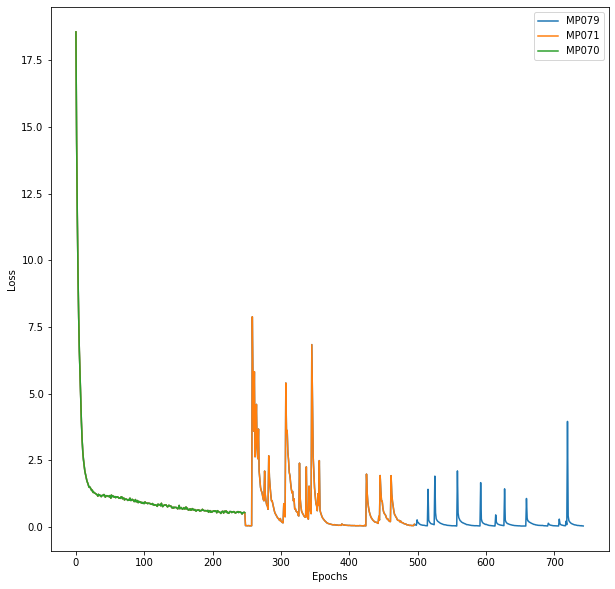

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP079.dynamics.model_loss_history.mean(axis=1), label='MP079')
ax.plot(MP071.dynamics.model_loss_history.mean(axis=1), label='MP071')
ax.plot(MP070.dynamics.model_loss_history.mean(axis=1), label='MP070')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

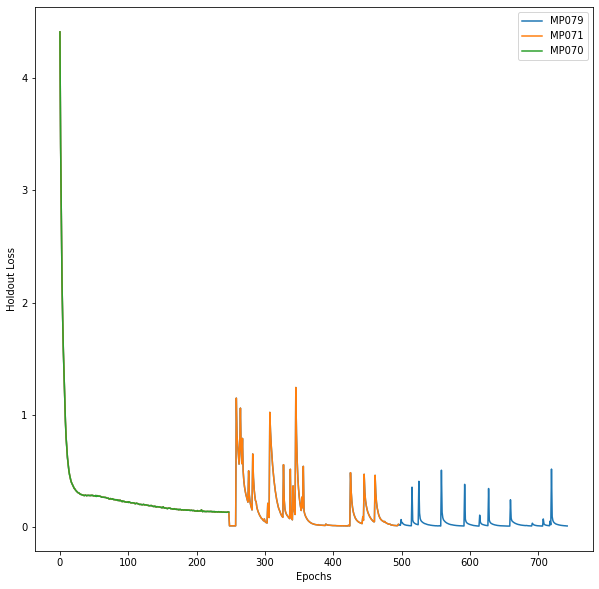

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP079.dynamics.model_holdout_loss_history.mean(axis=1), label='MP079')
ax.plot(MP071.dynamics.model_holdout_loss_history.mean(axis=1), label='MP071')
ax.plot(MP070.dynamics.model_holdout_loss_history.mean(axis=1), label='MP070')
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

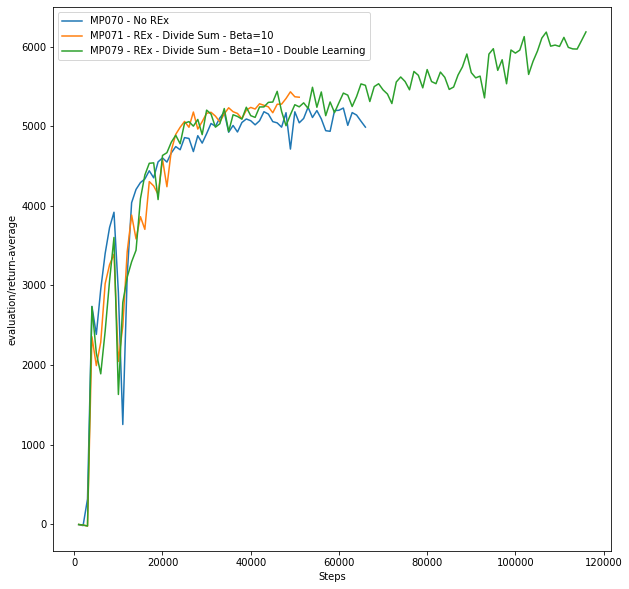

In [18]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP070.sac.result['timesteps_total'], MP070.sac.result[feature], label='MP070 - No REx')
ax.plot(MP071.sac.result['timesteps_total'], MP071.sac.result[feature], label='MP071 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

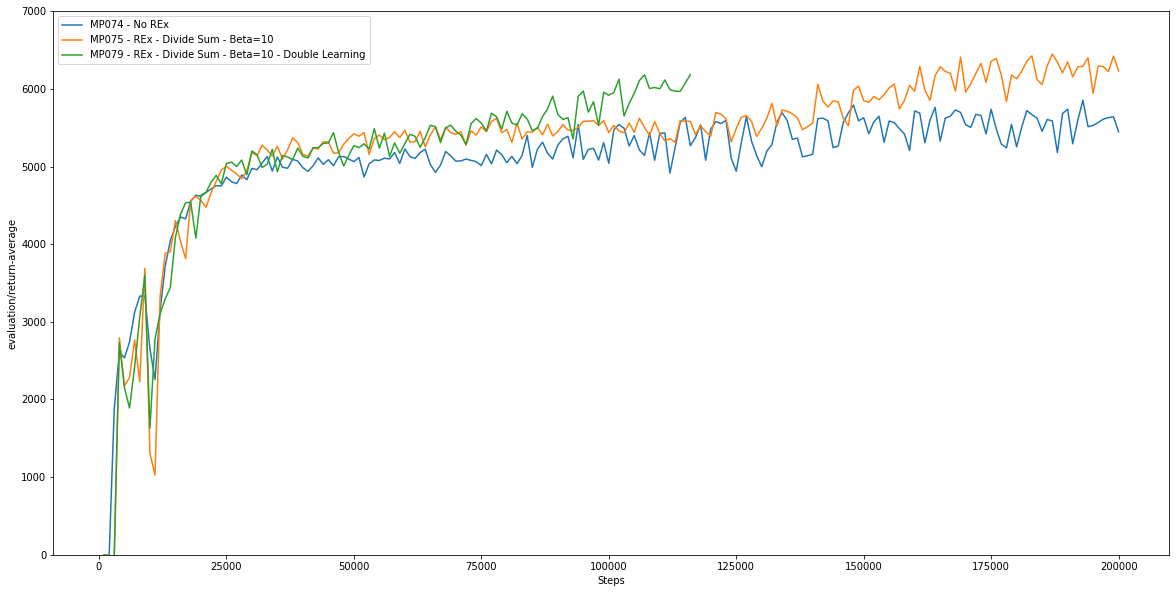

In [19]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
# ax.plot(MP070.sac.result['timesteps_total'], MP070.sac.result[feature], label='MP070 - No REx')
ax.plot(MP074.sac.result['timesteps_total'][:200], MP074.sac.result[feature][:200], label='MP074 - No REx')
# ax.plot(MP071.sac.result['timesteps_total'], MP071.sac.result[feature], label='MP071 - REx - Divide Sum - Beta=10')
ax.plot(MP075.sac.result['timesteps_total'][:200], MP075.sac.result[feature][:200], label='MP075 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.set_ylim(0,7000)
ax.legend()
pass

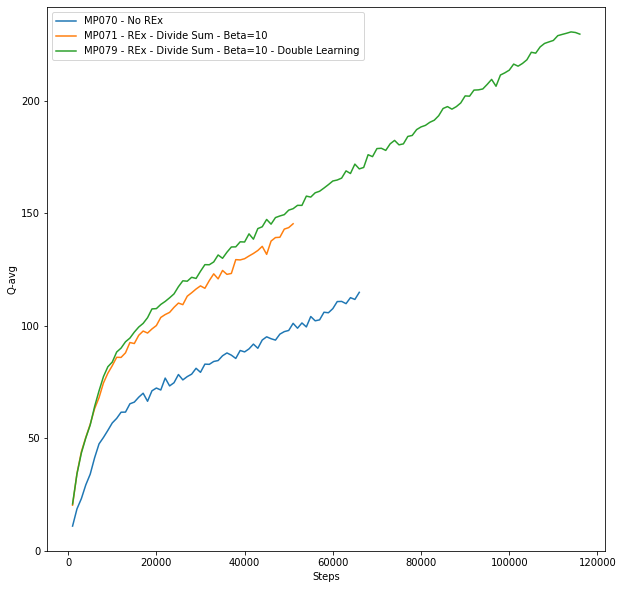

In [20]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP070.sac.result['timesteps_total'], MP070.sac.result[feature], label='MP070 - No REx')
ax.plot(MP071.sac.result['timesteps_total'], MP071.sac.result[feature], label='MP071 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

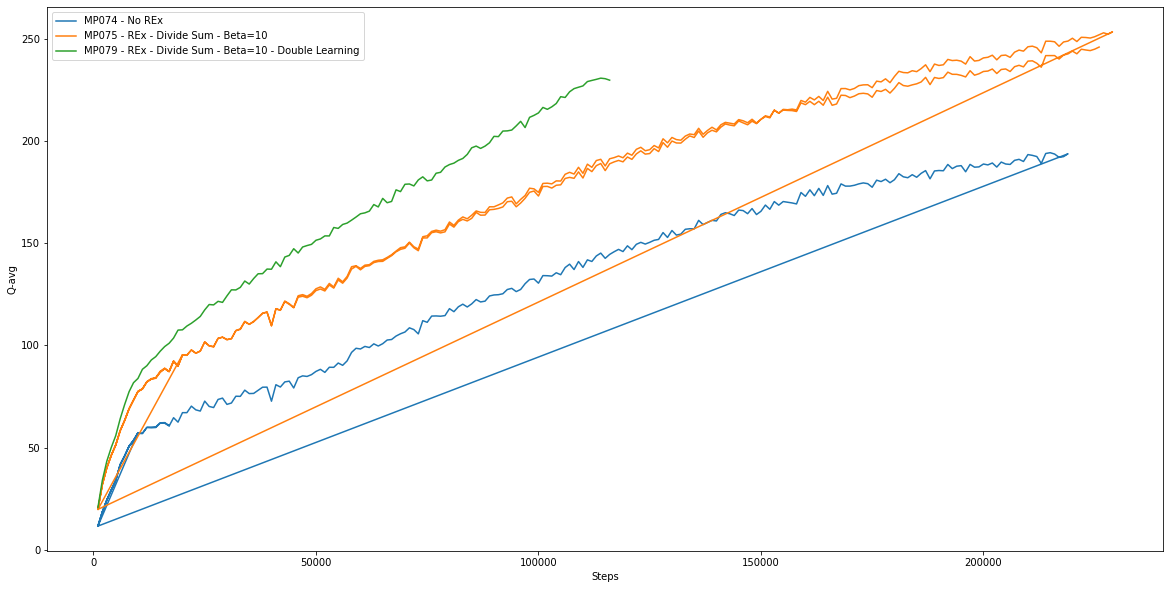

In [21]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP074.sac.result['timesteps_total'], MP074.sac.result[feature], label='MP074 - No REx')
ax.plot(MP075.sac.result['timesteps_total'], MP075.sac.result[feature], label='MP075 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

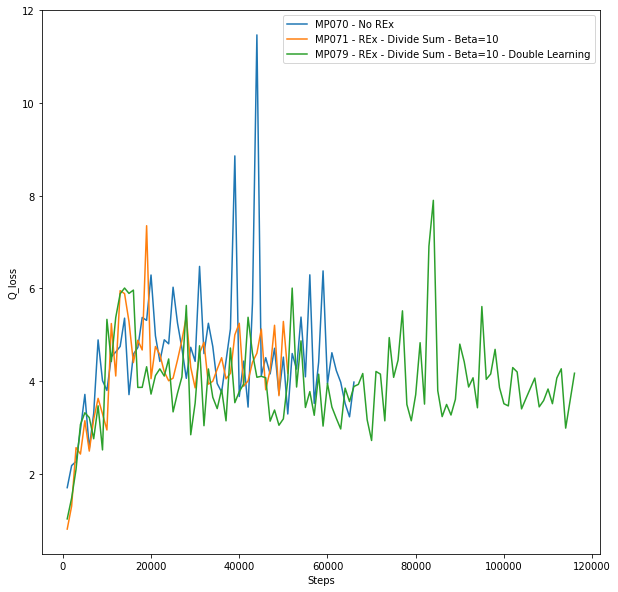

In [22]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP070.sac.result['timesteps_total'], MP070.sac.result[feature], label='MP070 - No REx')
ax.plot(MP071.sac.result['timesteps_total'], MP071.sac.result[feature], label='MP071 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

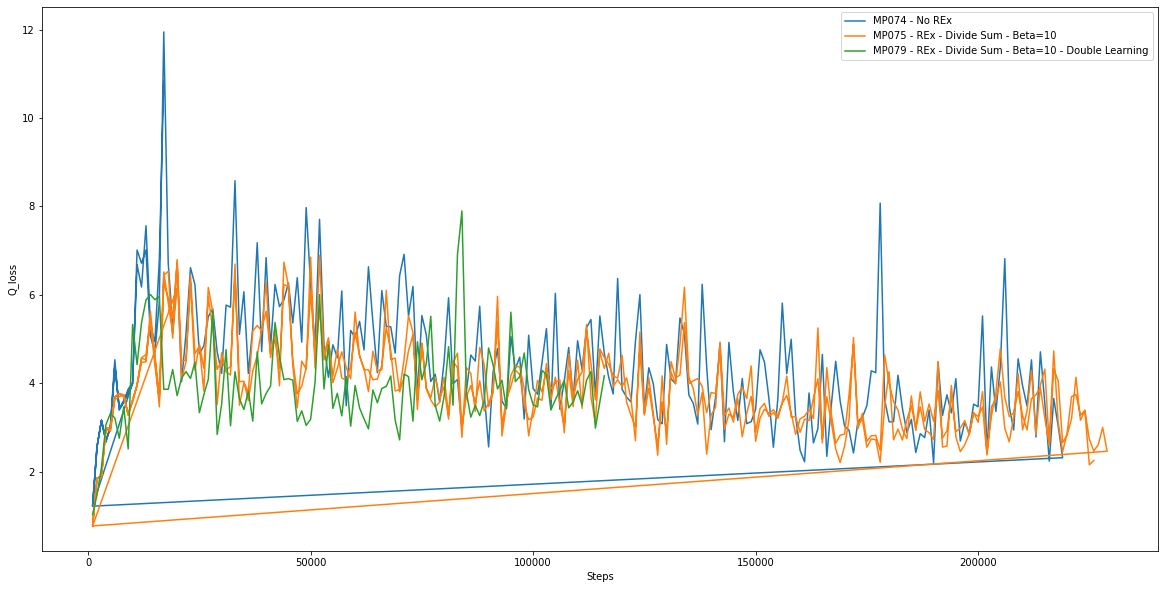

In [23]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP074.sac.result['timesteps_total'], MP074.sac.result[feature], label='MP074 - No REx')
ax.plot(MP075.sac.result['timesteps_total'], MP075.sac.result[feature], label='MP075 - REx - Divide Sum - Beta=10')
ax.plot(MP079.sac.result['timesteps_total'], MP079.sac.result[feature], label='MP079 - REx - Divide Sum - Beta=10 - Double Learning')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

# MP076-MP077

In [24]:
MP076 = get_results("MP076")
MP077 = get_results("MP077")

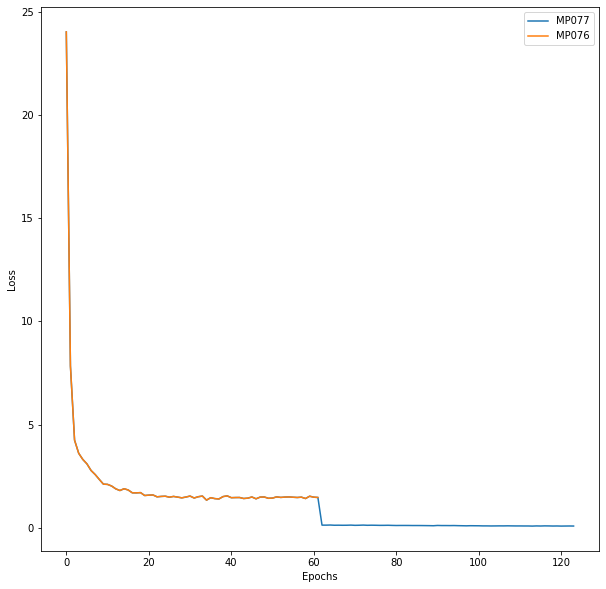

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP077.dynamics.model_loss_history.mean(axis=1), label='MP077')
ax.plot(MP076.dynamics.model_loss_history.mean(axis=1), label='MP076')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

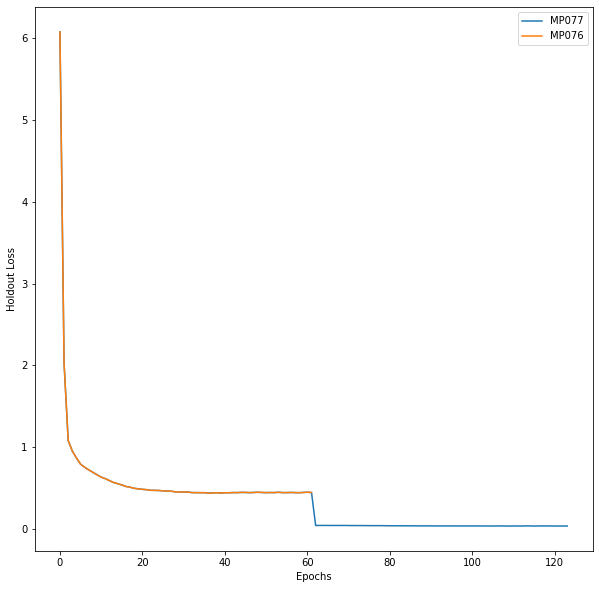

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP077.dynamics.model_holdout_loss_history.mean(axis=1), label='MP077')
ax.plot(MP076.dynamics.model_holdout_loss_history.mean(axis=1), label='MP076')
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

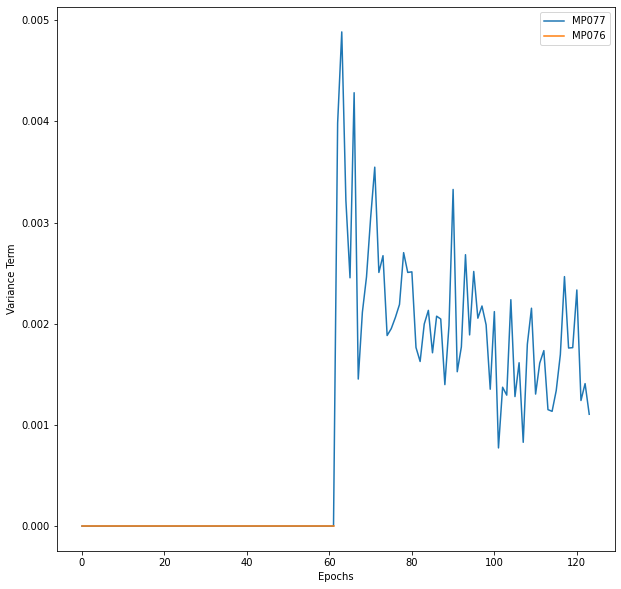

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP077.dynamics.model_pol_var_loss_history.mean(axis=1), label='MP077')
ax.plot(MP076.dynamics.model_pol_var_loss_history.mean(axis=1), label='MP076')
ax.set_xlabel('Epochs')
ax.set_ylabel('Variance Term')
ax.legend()
pass

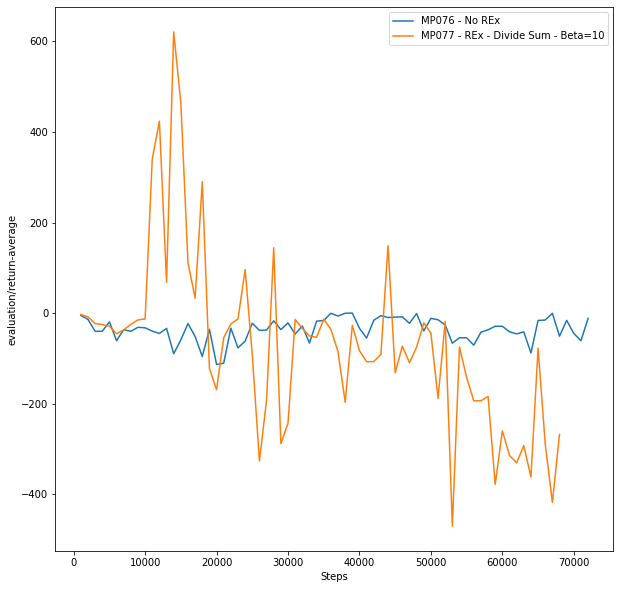

In [28]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP076.sac.result['timesteps_total'], MP076.sac.result[feature], label='MP076 - No REx')
ax.plot(MP077.sac.result['timesteps_total'], MP077.sac.result[feature], label='MP077 - REx - Divide Sum - Beta=10')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

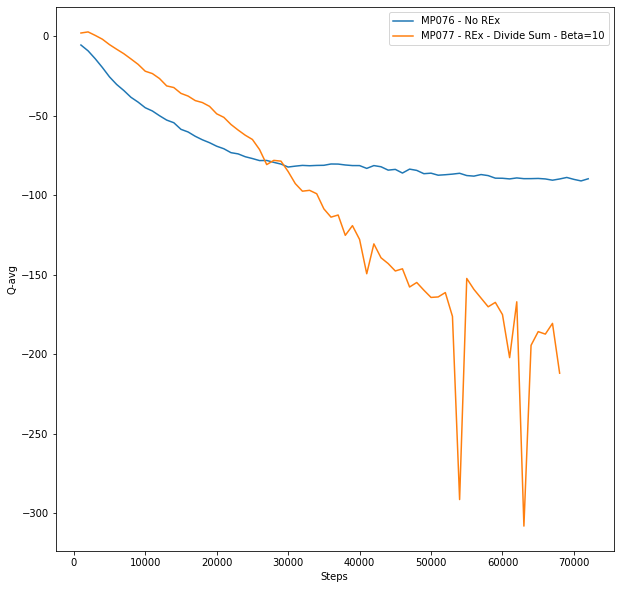

In [29]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP076.sac.result['timesteps_total'], MP076.sac.result[feature], label='MP076 - No REx')
ax.plot(MP077.sac.result['timesteps_total'], MP077.sac.result[feature], label='MP077 - REx - Divide Sum - Beta=10')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

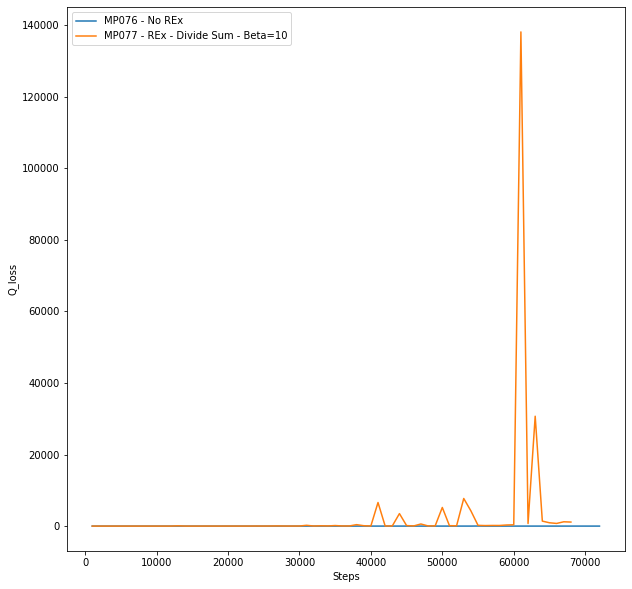

In [30]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP076.sac.result['timesteps_total'], MP076.sac.result[feature], label='MP076 - No REx')
ax.plot(MP077.sac.result['timesteps_total'], MP077.sac.result[feature], label='MP077 - REx - Divide Sum - Beta=10')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

# MP086-MP099

In [31]:
MP086 = get_results("MP086")
MP087 = get_results("MP087")
MP088 = get_results("MP088")
MP089 = get_results("MP089")
MP090 = get_results("MP090")
MP091 = get_results("MP091")
MP092 = get_results("MP092")
MP093 = get_results("MP093")
MP094 = get_results("MP094")
MP095 = get_results("MP095")
MP096 = get_results("MP096")
MP097 = get_results("MP097")
MP098 = get_results("MP098")
MP099 = get_results("MP099")

In [32]:
no_rex_h0_exps = [MP088, MP092, MP096]
no_rex_h4_exps = [MP086, MP090, MP094]
rex_h0_exps = [MP089, MP093, MP097]
rex_h4_exps = [MP087, MP091, MP095]

no_rex_exps = [*no_rex_h0_exps, *no_rex_h4_exps]
rex_exps = [*rex_h0_exps, *rex_h4_exps]
all_exps = [*no_rex_exps, *rex_exps]

min_no_rex_h0 = min([np.max(i.sac.result['timesteps_total']) for i in no_rex_h0_exps])
min_no_rex_h4 = min([np.max(i.sac.result['timesteps_total']) for i in no_rex_h4_exps])
min_rex_h0 = min([np.max(i.sac.result['timesteps_total']) for i in rex_h0_exps])
min_rex_h4 = min([np.max(i.sac.result['timesteps_total']) for i in rex_h4_exps])

min_no_rex = min(min_no_rex_h0, min_no_rex_h4)
min_rex = min(min_rex_h0, min_rex_h4)

min_no_rex_h0, min_no_rex_h4, min_rex_h0, min_rex_h4

(218000, 212000, 196000, 198000)

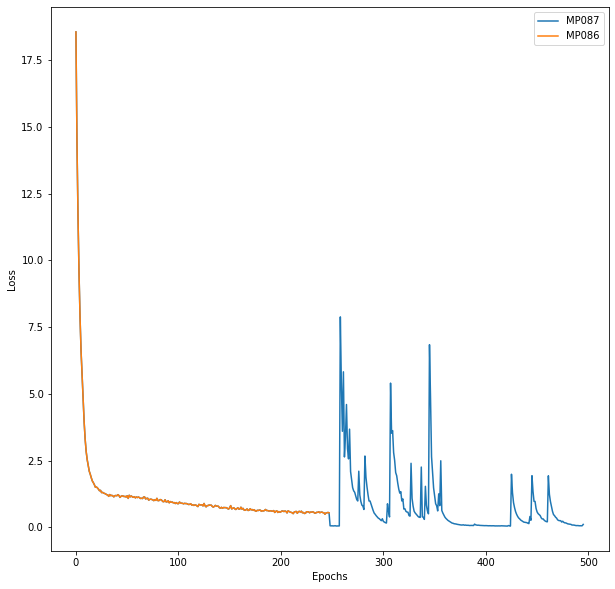

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP087.dynamics.model_loss_history.mean(axis=1), label='MP087')
ax.plot(MP086.dynamics.model_loss_history.mean(axis=1), label='MP086')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

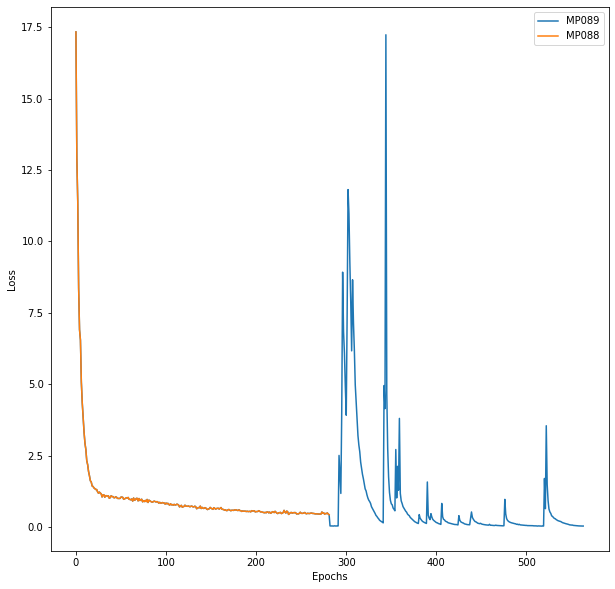

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP089.dynamics.model_loss_history.mean(axis=1), label='MP089')
ax.plot(MP088.dynamics.model_loss_history.mean(axis=1), label='MP088')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

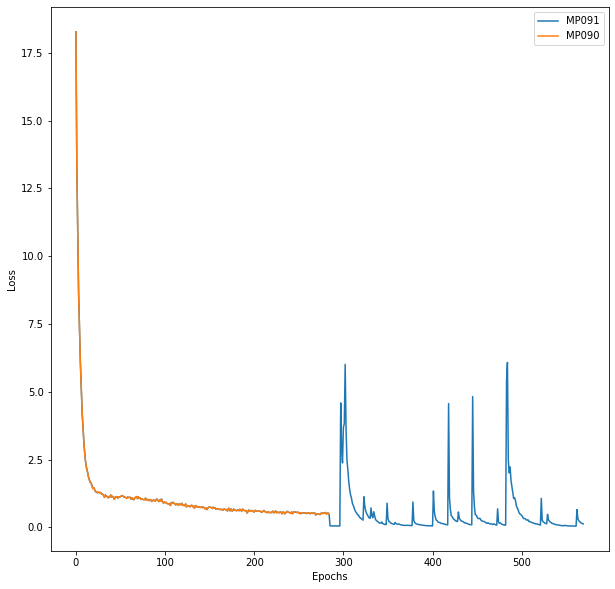

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP091.dynamics.model_loss_history.mean(axis=1), label='MP091')
ax.plot(MP090.dynamics.model_loss_history.mean(axis=1), label='MP090')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

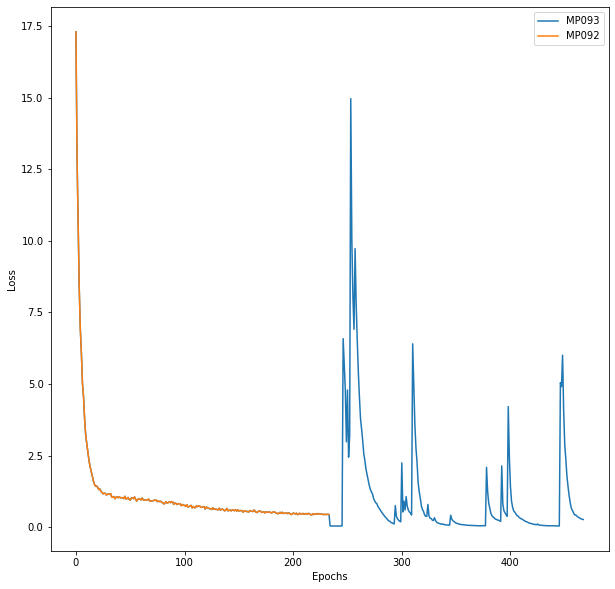

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP093.dynamics.model_loss_history.mean(axis=1), label='MP093')
ax.plot(MP092.dynamics.model_loss_history.mean(axis=1), label='MP092')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

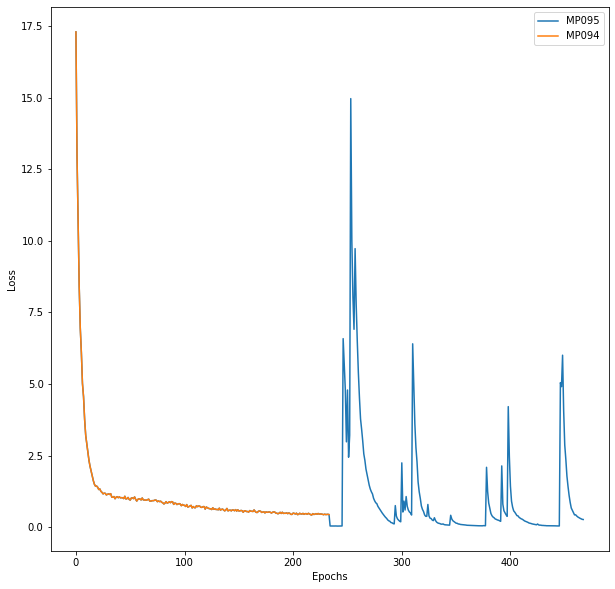

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP093.dynamics.model_loss_history.mean(axis=1), label='MP095')
ax.plot(MP092.dynamics.model_loss_history.mean(axis=1), label='MP094')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

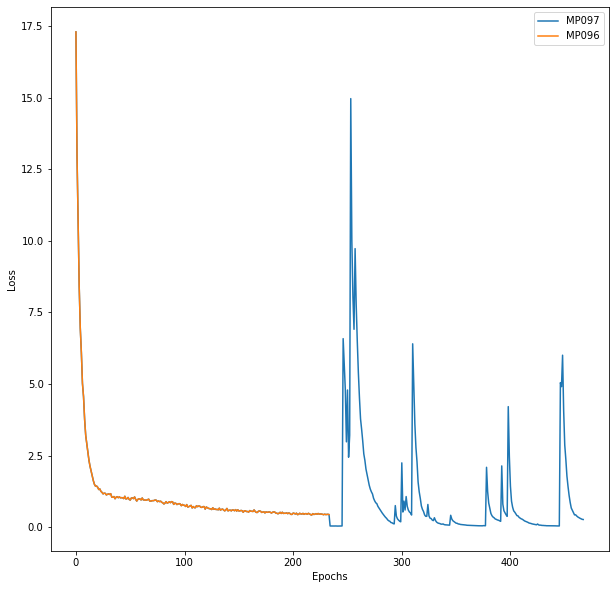

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP093.dynamics.model_loss_history.mean(axis=1), label='MP097')
ax.plot(MP092.dynamics.model_loss_history.mean(axis=1), label='MP096')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

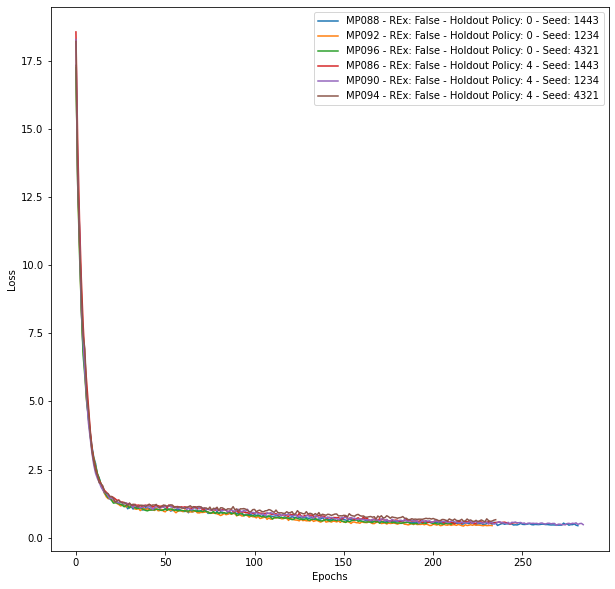

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in no_rex_exps: 
    ax.plot(exp.dynamics.model_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

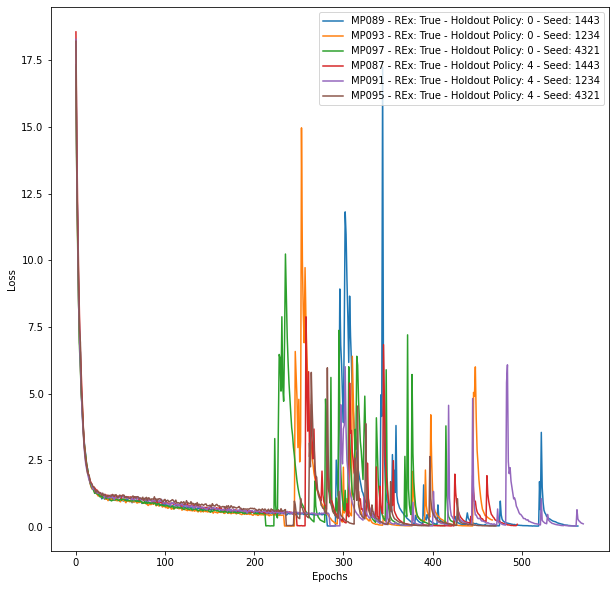

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in rex_exps: 
    ax.plot(exp.dynamics.model_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

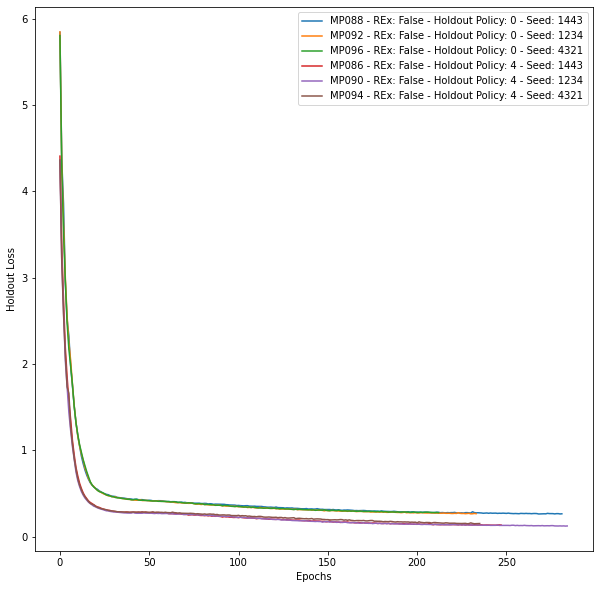

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in no_rex_exps: 
    ax.plot(exp.dynamics.model_holdout_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

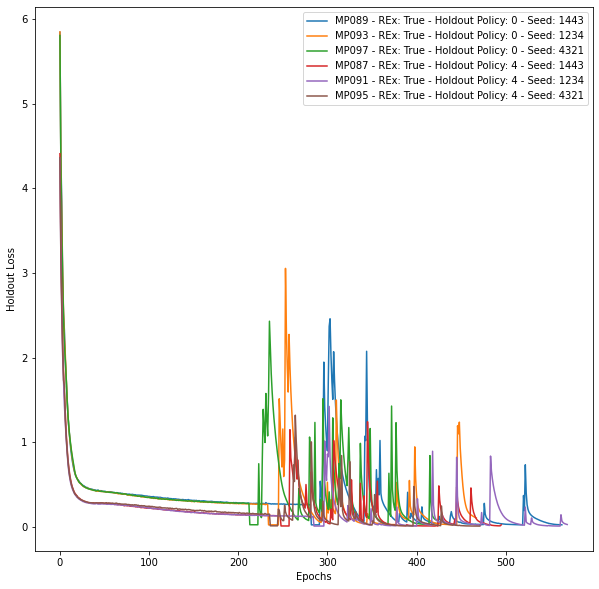

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in rex_exps: 
    ax.plot(exp.dynamics.model_holdout_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

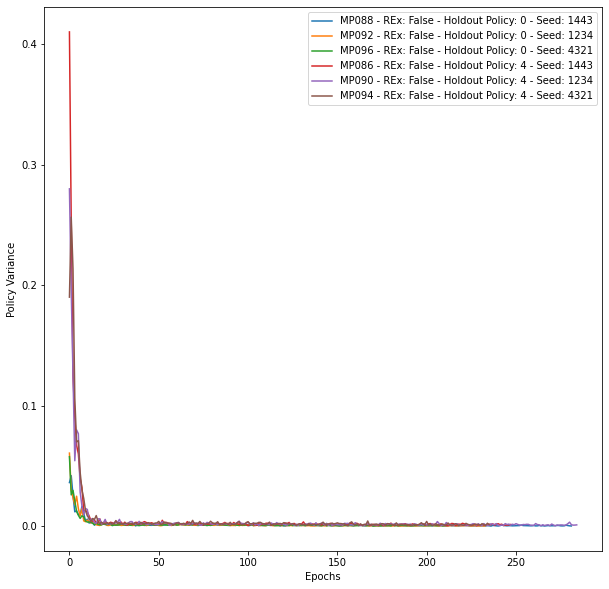

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in no_rex_exps: 
    ax.plot(exp.dynamics.model_pol_var_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Policy Variance')
ax.legend()
pass

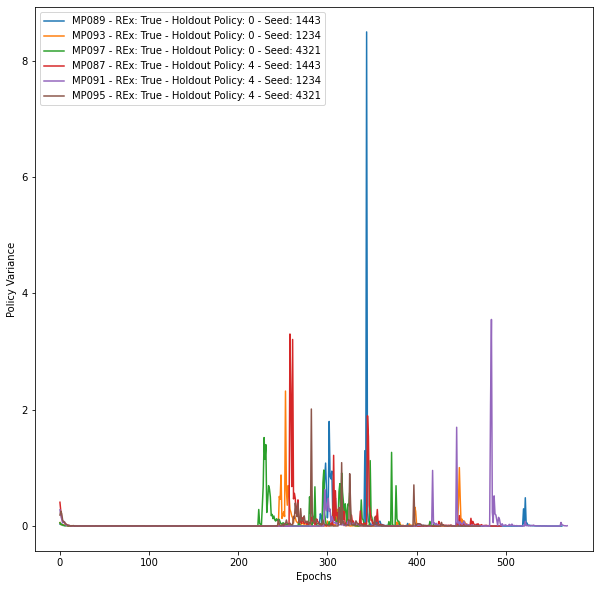

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in rex_exps: 
    ax.plot(exp.dynamics.model_pol_var_loss_history.mean(axis=1), label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Policy Variance')
ax.legend()
pass

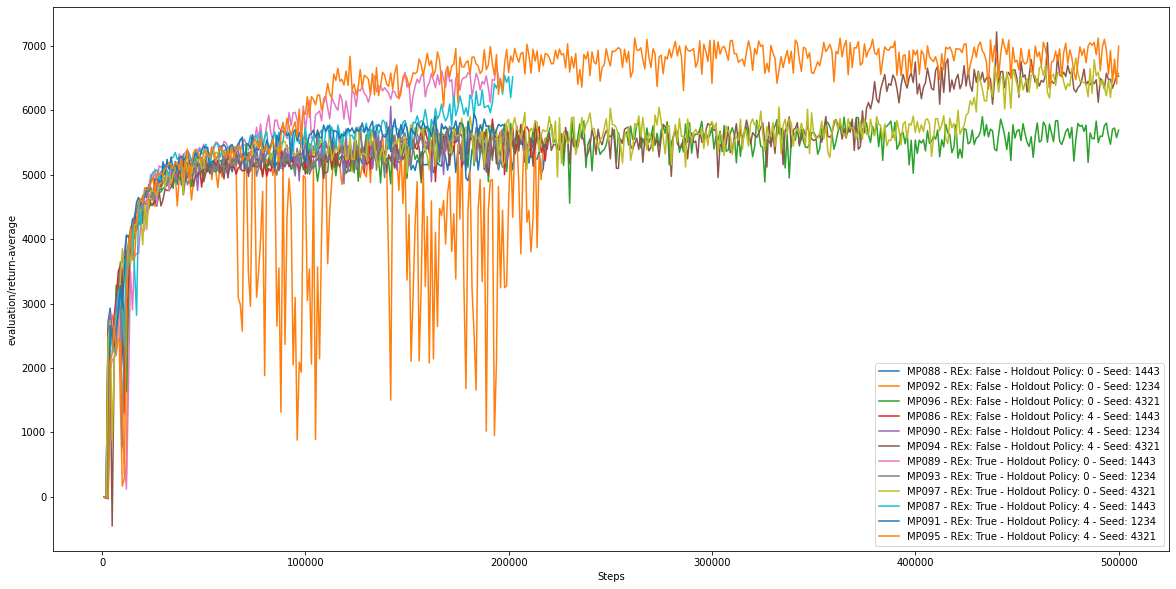

In [45]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in all_exps: 
    ax.plot(exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

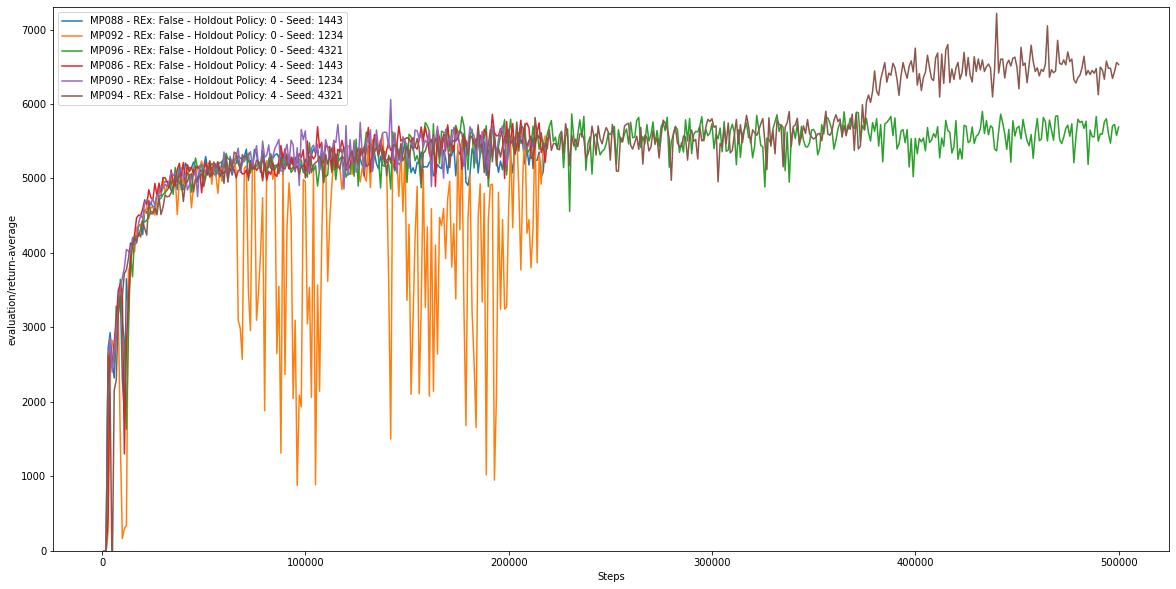

In [46]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in no_rex_exps: 
    ax.plot(exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.set_ylim(0, 7300)
ax.legend()
pass

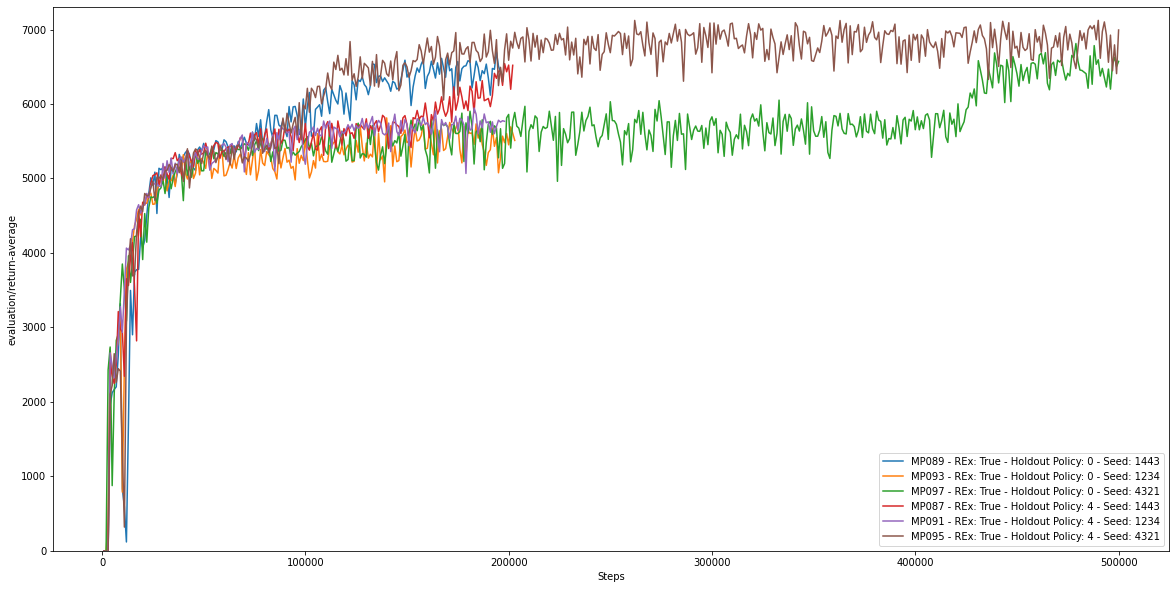

In [47]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in rex_exps: 
    ax.plot(exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Holdout Policy: {exp.holdout_policy} - Seed: {exp.seed}')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.set_ylim(0, 7300)
ax.legend()
pass

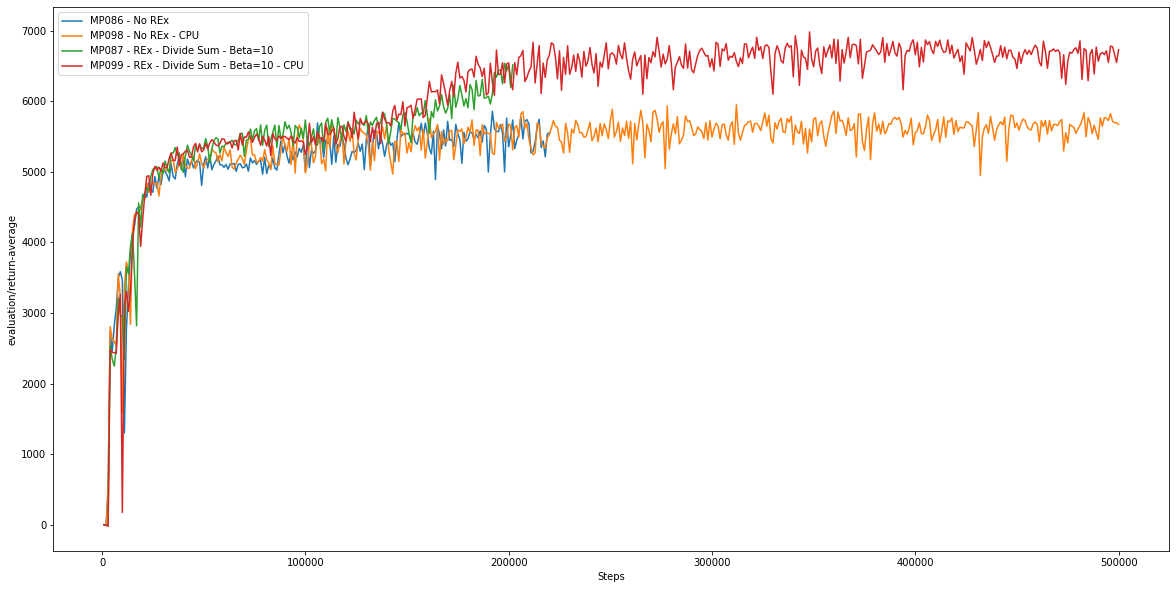

In [48]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP086.sac.result['timesteps_total'], MP086.sac.result[feature], label='MP086 - No REx')
ax.plot(MP098.sac.result['timesteps_total'], MP098.sac.result[feature], label='MP098 - No REx - CPU')
ax.plot(MP087.sac.result['timesteps_total'], MP087.sac.result[feature], label='MP087 - REx - Divide Sum - Beta=10')
ax.plot(MP099.sac.result['timesteps_total'], MP099.sac.result[feature], label='MP099 - REx - Divide Sum - Beta=10 - CPU')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

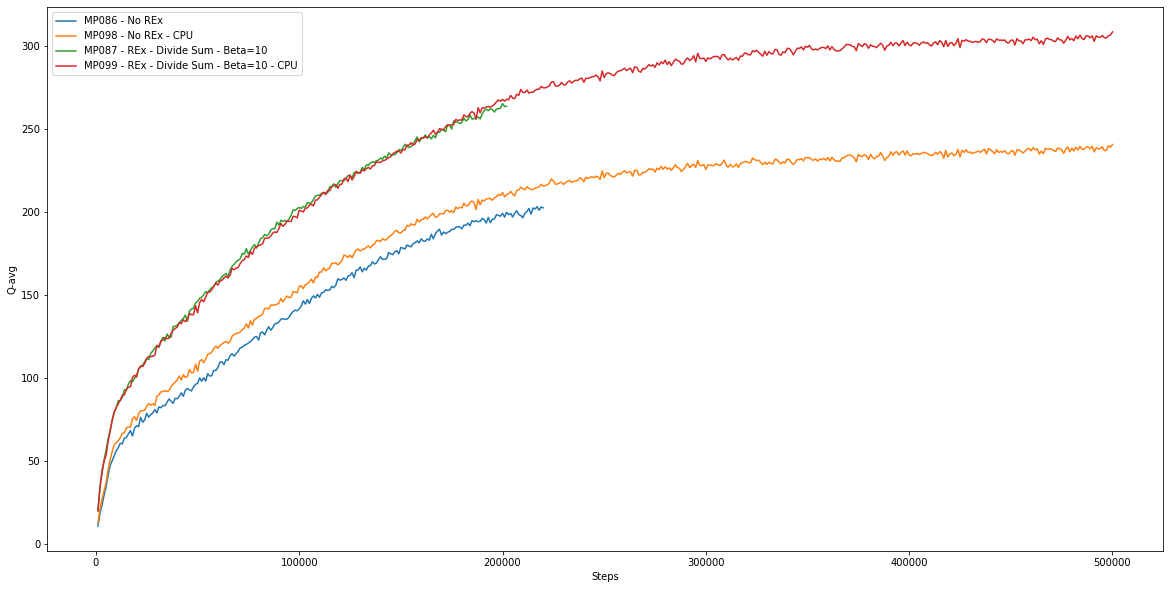

In [49]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP086.sac.result['timesteps_total'], MP086.sac.result[feature], label='MP086 - No REx')
ax.plot(MP098.sac.result['timesteps_total'], MP098.sac.result[feature], label='MP098 - No REx - CPU')
ax.plot(MP087.sac.result['timesteps_total'], MP087.sac.result[feature], label='MP087 - REx - Divide Sum - Beta=10')
ax.plot(MP099.sac.result['timesteps_total'], MP099.sac.result[feature], label='MP099 - REx - Divide Sum - Beta=10 - CPU')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

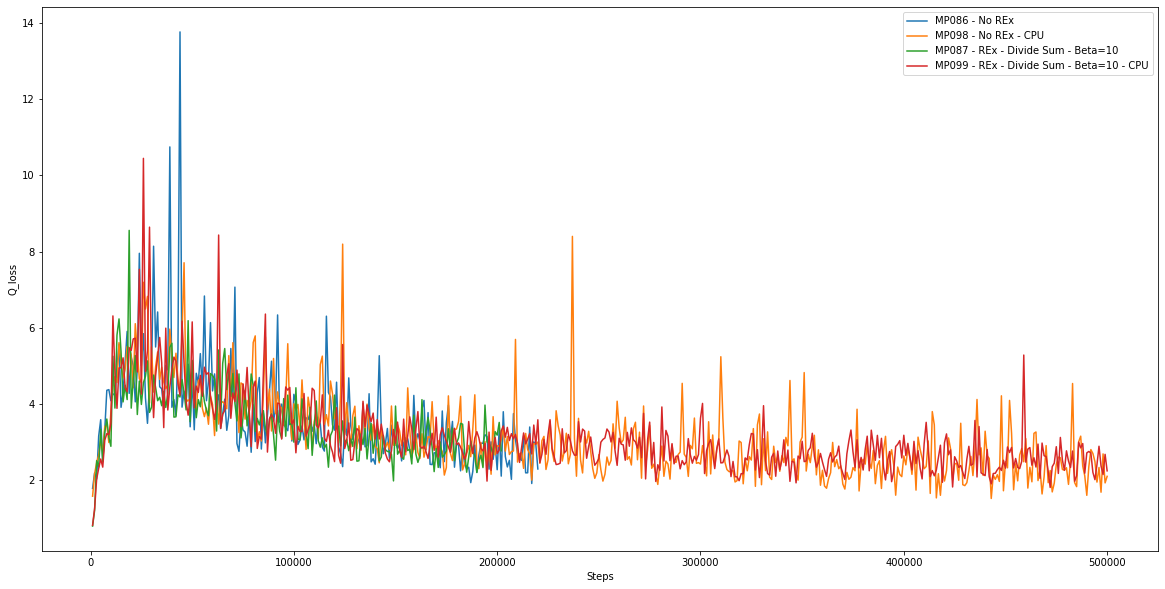

In [50]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.plot(MP086.sac.result['timesteps_total'], MP086.sac.result[feature], label='MP086 - No REx')
ax.plot(MP098.sac.result['timesteps_total'], MP098.sac.result[feature], label='MP098 - No REx - CPU')
ax.plot(MP087.sac.result['timesteps_total'], MP087.sac.result[feature], label='MP087 - REx - Divide Sum - Beta=10')
ax.plot(MP099.sac.result['timesteps_total'], MP099.sac.result[feature], label='MP099 - REx - Divide Sum - Beta=10 - CPU')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

# MP0100-MP0111

In [65]:
MP100 = get_results("MP100")
MP101 = get_results("MP101")
MP102 = get_results("MP102")
MP103 = get_results("MP103")
MP104 = get_results("MP104")
MP105 = get_results("MP105")
MP106 = get_results("MP106")
MP107 = get_results("MP107")
MP108 = get_results("MP108")
MP109 = get_results("MP109")
MP110 = get_results("MP110")
MP111 = get_results("MP111")

In [160]:
d3rlpy_pap5_dynamics_stats_df = pd.DataFrame([
    {
        'name': exp.name,
        'dataset': exp.dataset,
        'rex': exp.rex,
        'seed': exp.seed,
        'training_epochs': exp.dynamics.model_loss_history.shape[0],
        'final_policy_loss_sum_mean': exp.dynamics.model_pol_total_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_holdout_policy_loss_sum_mean': exp.dynamics.model_holdout_pol_total_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_policy_loss_sum_var': exp.dynamics.model_pol_total_loss_history.iloc[-5:].mean(axis=1).var(),
        'final_holdout_policy_loss_sum_var': exp.dynamics.model_holdout_pol_total_loss_history.iloc[-5:].mean(axis=1).var(),
        'final_policy_variance': exp.dynamics.model_pol_var_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_holdout_policy_variance': exp.dynamics.model_holdout_pol_var_loss_history.iloc[-5:].mean(axis=1).mean()
    }
for exp in [
    MP100,
    MP101,
    MP104,
    MP105,
    MP108,
    MP109,
    MP102,
    MP103,
    MP106,
    MP107,
    MP110,
    MP111,
]])
d3rlpy_pap5_dynamics_stats_df

name           dataset    rex  seed  training_epochs  \
0   MP100  D3RLPY-PAP5-P0-3  False  1443              588   
1   MP101  D3RLPY-PAP5-P0-3   True  1443              588   
2   MP104  D3RLPY-PAP5-P0-3  False  1234              494   
3   MP105  D3RLPY-PAP5-P0-3   True  1234              494   
4   MP108  D3RLPY-PAP5-P0-3  False  4321              538   
5   MP109  D3RLPY-PAP5-P0-3   True  4321              538   
6   MP102  D3RLPY-PAP5-P1-4  False  1443              692   
7   MP103  D3RLPY-PAP5-P1-4   True  1443              692   
8   MP106  D3RLPY-PAP5-P1-4  False  1234              342   
9   MP107  D3RLPY-PAP5-P1-4   True  1234              342   
10  MP110  D3RLPY-PAP5-P1-4  False  4321              450   
11  MP111  D3RLPY-PAP5-P1-4   True  4321              450   

    final_policy_loss_sum_mean  final_holdout_policy_loss_sum_mean  \
0                     0.349975                            0.376416   
1                     0.470090                            0.506765   
2                     0.379132                            0.554348   
3                     1.006340                            1.190426   
4                     0.377769                            0.545482   
5                     0.357920                            0.532672   
6                     0.317987                            0.306050   
7                     1.125333                            1.100883   
8                     0.372966                            0.439001   
9                     2.537497                            2.620930   
10                    0.318756                            0.409219   
11                    0.405443                            0.491479   

    final_policy_loss_sum_var  final_holdout_policy_loss_sum_var  \
0                    0.000672                           0.000017   
1                    0.004455                           0.002873   
2                    0.000370                           0.000010   
3                    0.263577                           0.274436   
4                    0.000609                           0.000004   
5                    0.000446                           0.000043   
6                    0.001566                           0.001845   
7                    0.418865                           0.425921   
8                    0.000097                           0.000010   
9                    0.257237                           0.264576   
10                   0.000376                           0.000011   
11                   0.000115                           0.000140   

    final_policy_variance  final_holdout_policy_variance  
0                0.001173                       0.002899  
1                0.000543                       0.002195  
2                0.001325                       0.009111  
3                0.003815                       0.012689  
4                0.000871                       0.004503  
5                0.000276                       0.004325  
6                0.000345                       0.000458  
7                0.000897                       0.001263  
8                0.000314                       0.000724  
9                0.005639                       0.004730  
10               0.000268                       0.000364  
11               0.000274                       0.000212

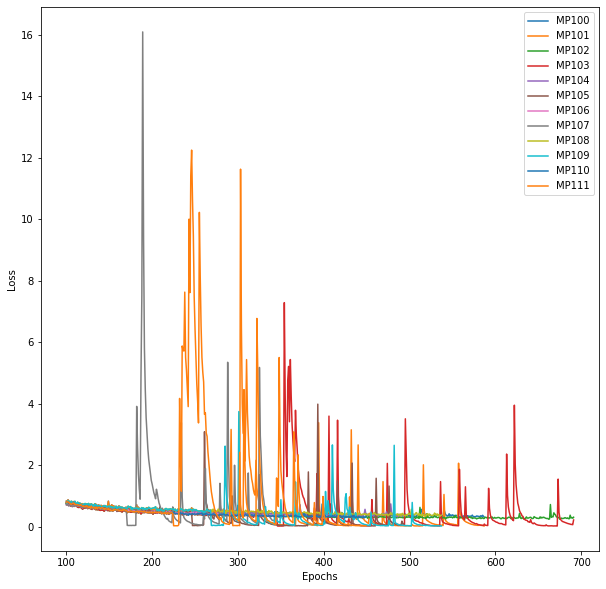

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP100,
    MP101,
    MP102,
    MP103,
    MP104,
    MP105,
    MP106,
    MP107,
    MP108,
    MP109,
    MP110,
    MP111,
]:
    ax.plot(exp.dynamics.model_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

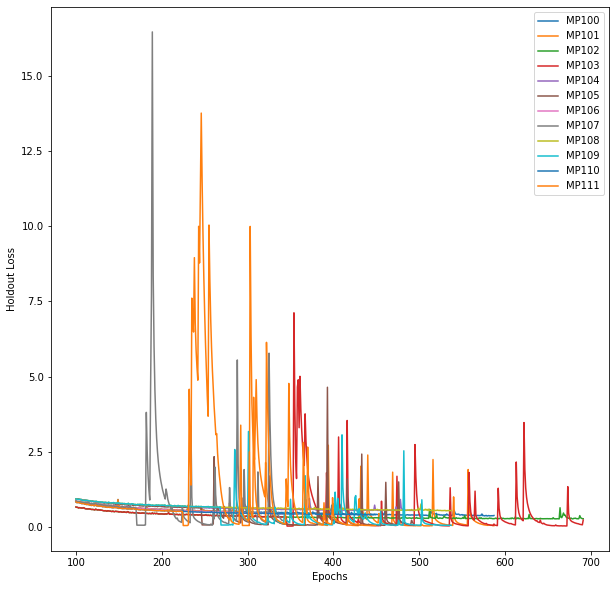

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP100,
    MP101,
    MP102,
    MP103,
    MP104,
    MP105,
    MP106,
    MP107,
    MP108,
    MP109,
    MP110,
    MP111,
]:
    ax.plot(exp.dynamics.model_holdout_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
ax.legend()
pass

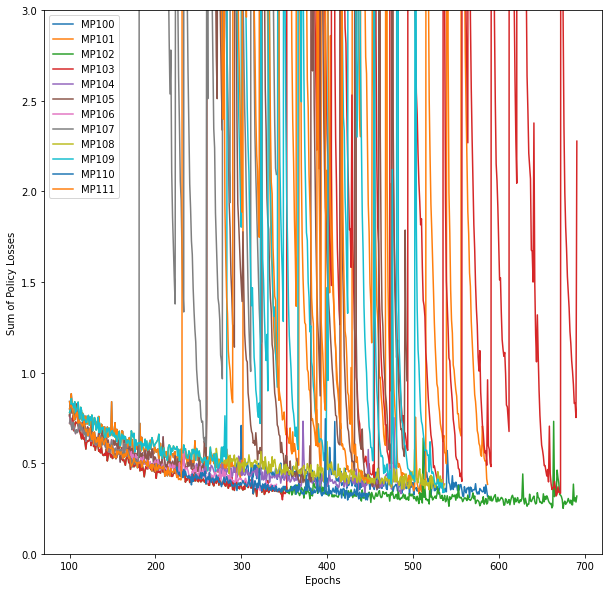

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP100,
    MP101,
    MP102,
    MP103,
    MP104,
    MP105,
    MP106,
    MP107,
    MP108,
    MP109,
    MP110,
    MP111,
]:
    ax.plot(exp.dynamics.model_pol_total_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Sum of Policy Losses')
ax.set_ylim(0,3)
ax.legend()
pass

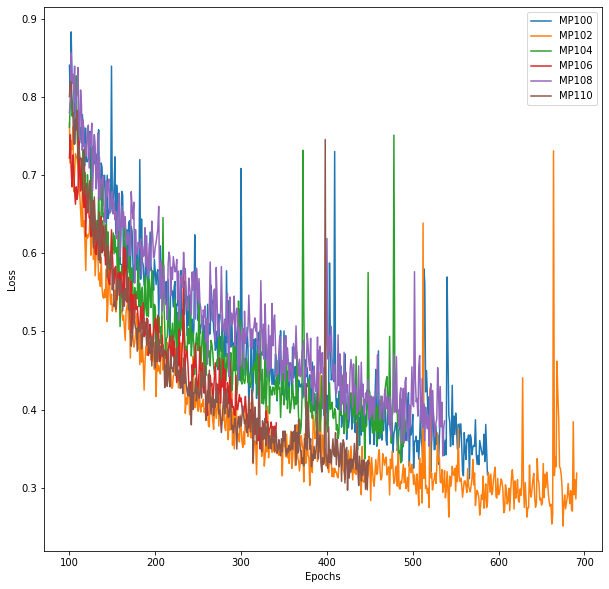

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP100,
    # MP101,
    MP102,
    # MP103,
    MP104,
    # MP105,
    MP106,
    # MP107,
    MP108,
    # MP109,
    MP110,
    # MP111,
]:
    ax.plot(exp.dynamics.model_pol_total_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
# ax.set_ylim(0,5)
ax.legend()
pass

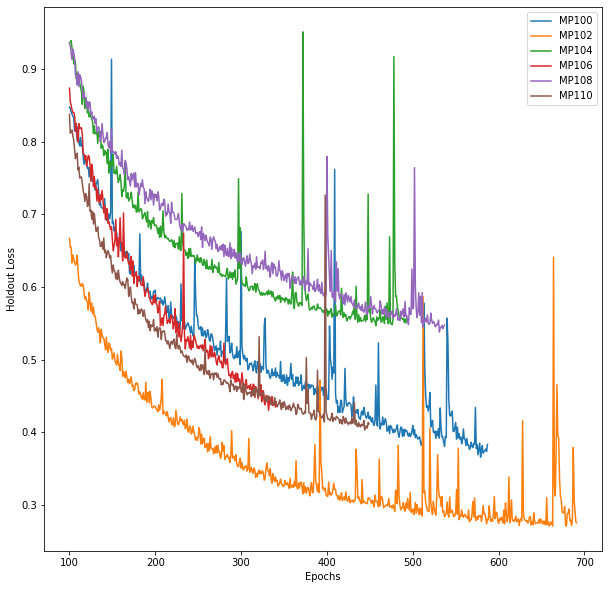

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP100,
    # MP101,
    MP102,
    # MP103,
    MP104,
    # MP105,
    MP106,
    # MP107,
    MP108,
    # MP109,
    MP110,
    # MP111,
]:
    ax.plot(exp.dynamics.model_holdout_pol_total_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Holdout Loss')
# ax.set_ylim(0,5)
ax.legend()
pass

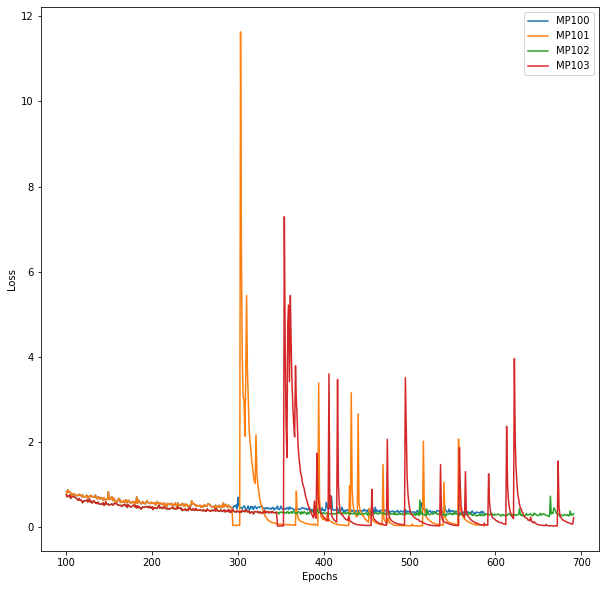

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(MP100.dynamics.model_loss_history.mean(axis=1)[100:], label='MP100')
ax.plot(MP101.dynamics.model_loss_history.mean(axis=1)[100:], label='MP101')
ax.plot(MP102.dynamics.model_loss_history.mean(axis=1)[100:], label='MP102')
ax.plot(MP103.dynamics.model_loss_history.mean(axis=1)[100:], label='MP103')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

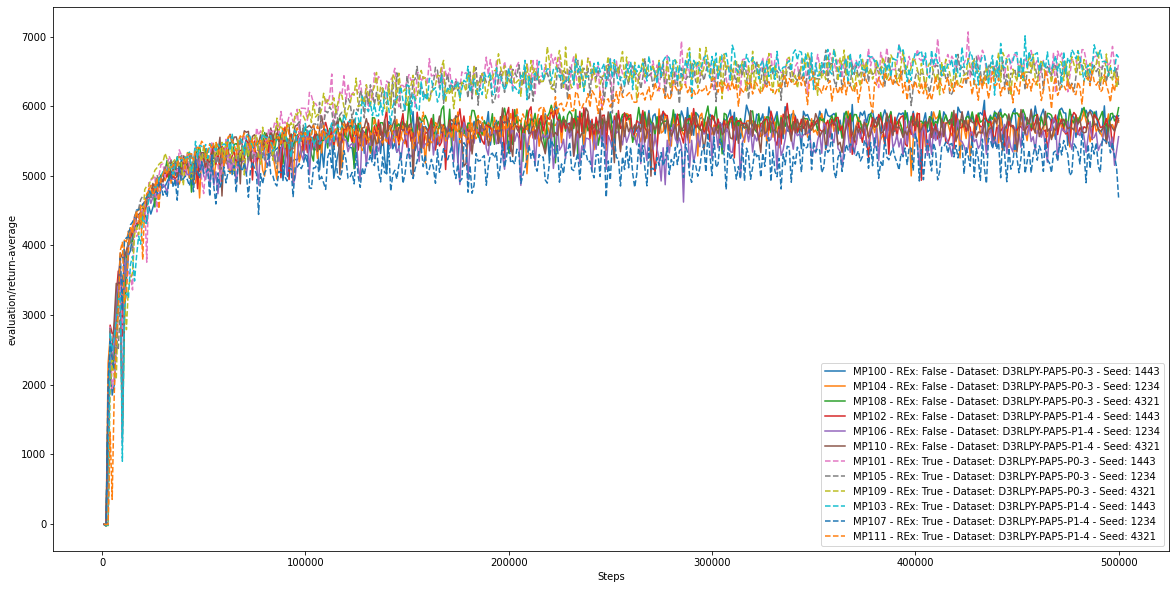

In [82]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP100,
    MP104,
    MP108,
    MP102,
    MP106,
    MP110,
    MP101,
    MP105,
    MP109,
    MP103,
    MP107,
    MP111,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

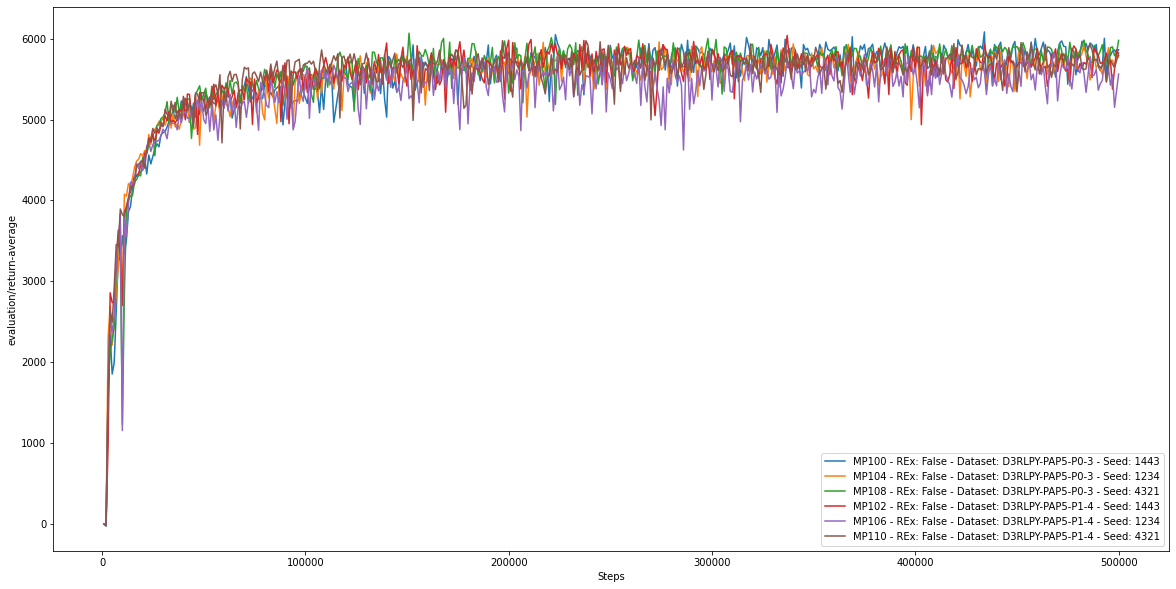

In [76]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP100,
    MP104,
    MP108,
    MP102,
    MP106,
    MP110,
]:
    ax.plot(exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

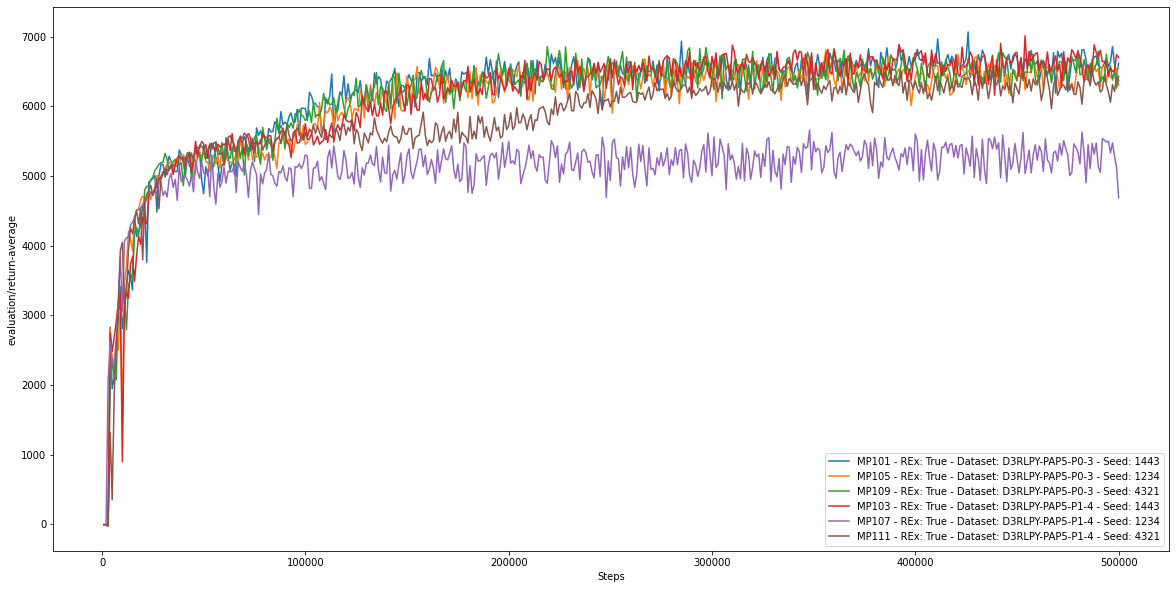

In [77]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP101,
    MP105,
    MP109,
    MP103,
    MP107,
    MP111,
]:
    ax.plot(exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}')
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

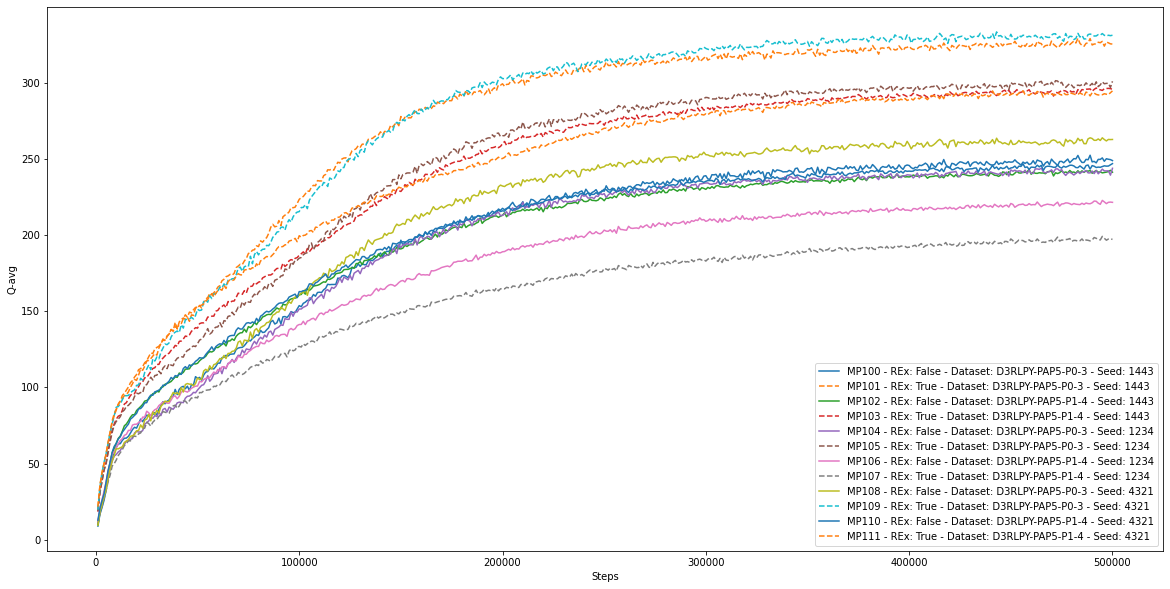

In [80]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP100,
    MP101,
    MP102,
    MP103,
    MP104,
    MP105,
    MP106,
    MP107,
    MP108,
    MP109,
    MP110,
    MP111,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

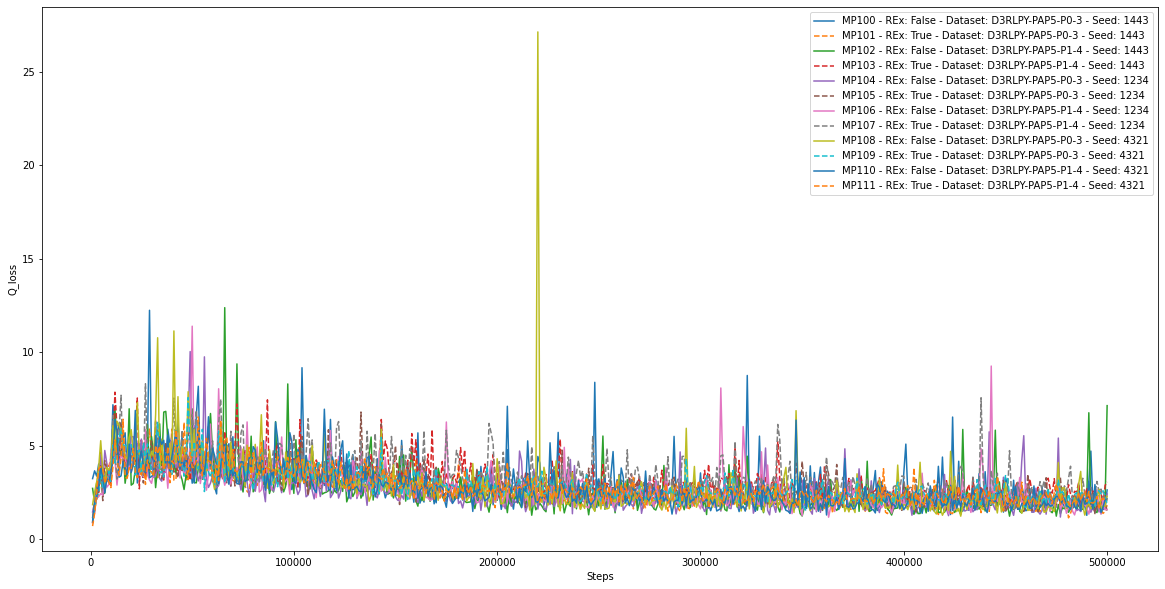

In [81]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP100,
    MP101,
    MP102,
    MP103,
    MP104,
    MP105,
    MP106,
    MP107,
    MP108,
    MP109,
    MP110,
    MP111,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

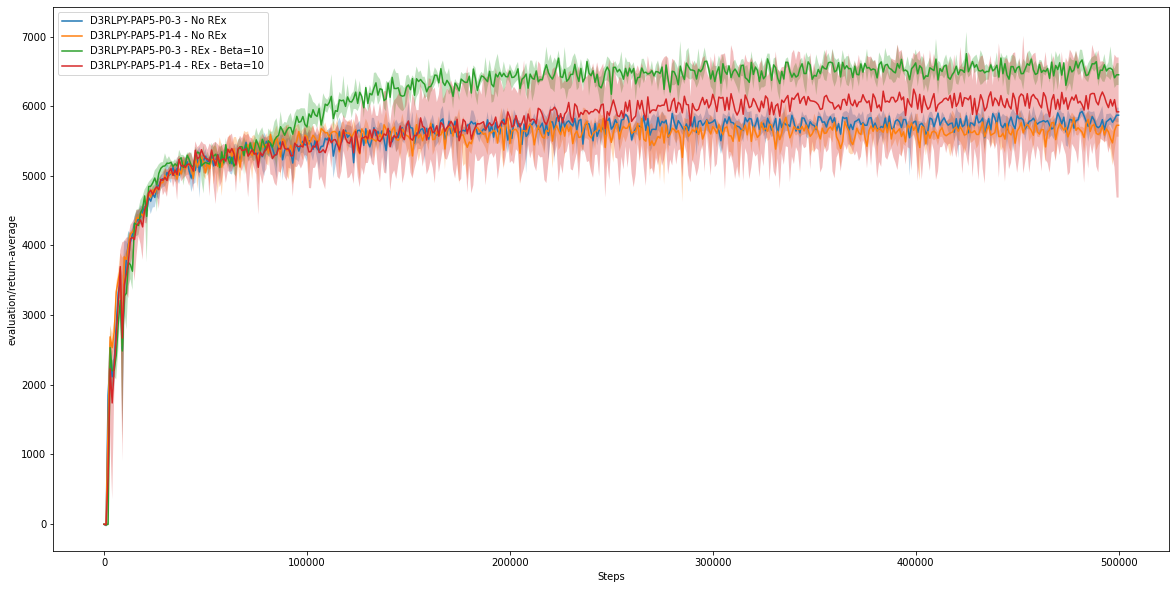

In [183]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
d3rlpy_pap5_p0_3_no_rex = np.vstack((MP100.sac.result[feature], MP104.sac.result[feature], MP108.sac.result[feature]))
d3rlpy_pap5_p1_4_no_rex = np.vstack((MP102.sac.result[feature], MP106.sac.result[feature], MP110.sac.result[feature]))
d3rlpy_pap5_p0_3_rex =    np.vstack((MP101.sac.result[feature], MP105.sac.result[feature], MP109.sac.result[feature]))
d3rlpy_pap5_p1_4_rex =    np.vstack((MP103.sac.result[feature], MP107.sac.result[feature], MP111.sac.result[feature]))

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.min(axis=0), d3rlpy_pap5_p0_3_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.min(axis=0), d3rlpy_pap5_p1_4_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.min(axis=0), d3rlpy_pap5_p0_3_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.min(axis=0), d3rlpy_pap5_p1_4_rex.max(axis=0), alpha=0.3)

ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

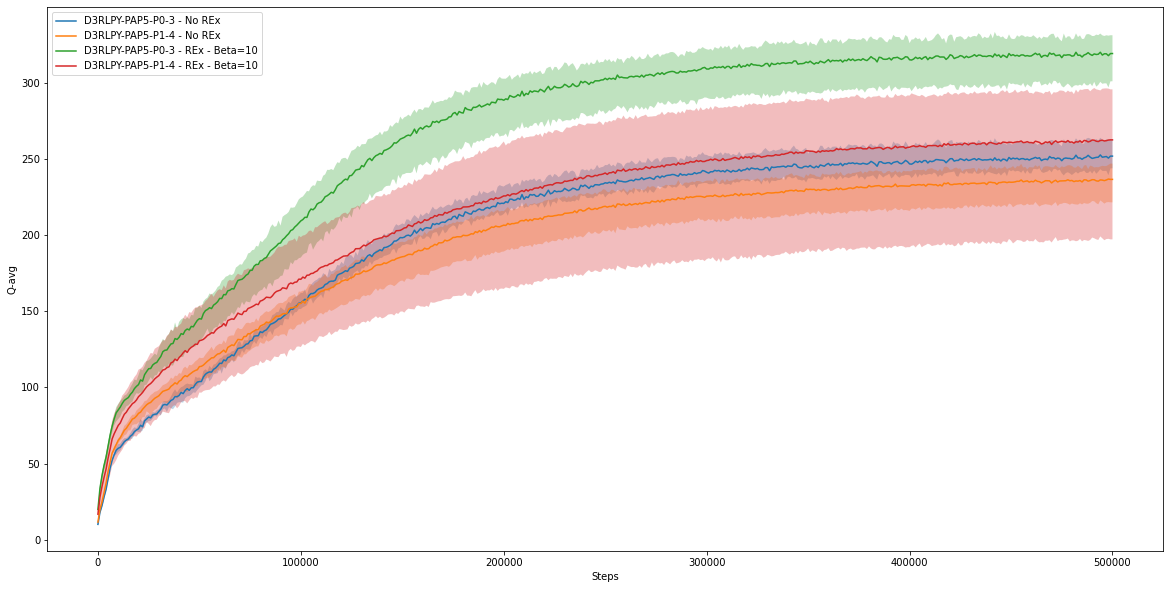

In [184]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
d3rlpy_pap5_p0_3_no_rex = np.vstack((MP100.sac.result[feature], MP104.sac.result[feature], MP108.sac.result[feature]))
d3rlpy_pap5_p1_4_no_rex = np.vstack((MP102.sac.result[feature], MP106.sac.result[feature], MP110.sac.result[feature]))
d3rlpy_pap5_p0_3_rex =    np.vstack((MP101.sac.result[feature], MP105.sac.result[feature], MP109.sac.result[feature]))
d3rlpy_pap5_p1_4_rex =    np.vstack((MP103.sac.result[feature], MP107.sac.result[feature], MP111.sac.result[feature]))

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.min(axis=0), d3rlpy_pap5_p0_3_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.min(axis=0), d3rlpy_pap5_p1_4_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.min(axis=0), d3rlpy_pap5_p0_3_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.min(axis=0), d3rlpy_pap5_p1_4_rex.max(axis=0), alpha=0.3)

ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

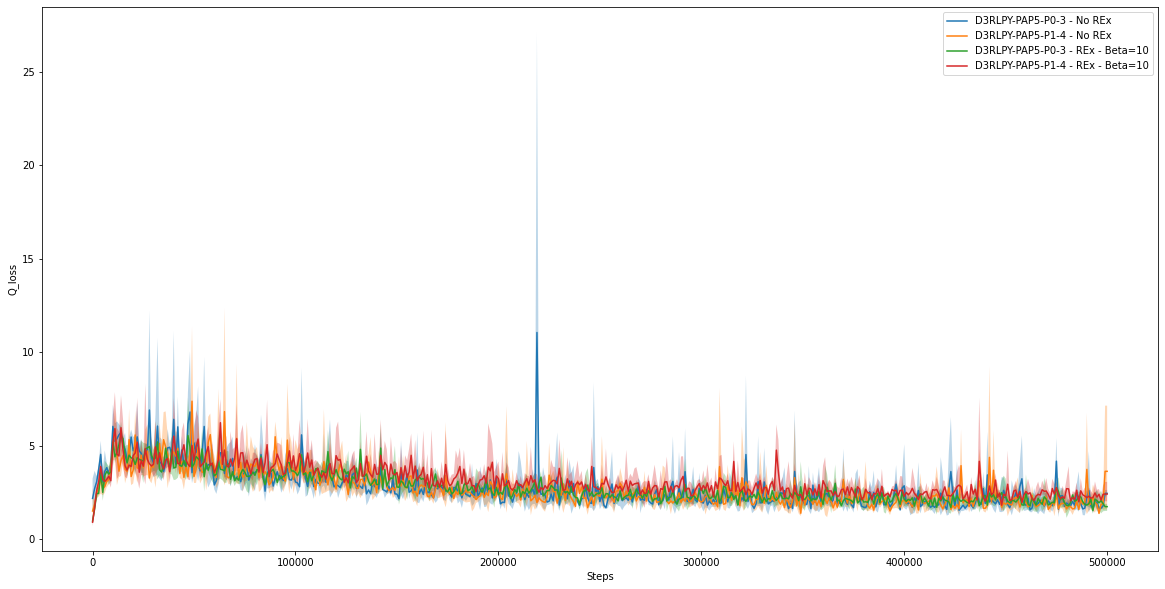

In [185]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
d3rlpy_pap5_p0_3_no_rex = np.vstack((MP100.sac.result[feature], MP104.sac.result[feature], MP108.sac.result[feature]))
d3rlpy_pap5_p1_4_no_rex = np.vstack((MP102.sac.result[feature], MP106.sac.result[feature], MP110.sac.result[feature]))
d3rlpy_pap5_p0_3_rex =    np.vstack((MP101.sac.result[feature], MP105.sac.result[feature], MP109.sac.result[feature]))
d3rlpy_pap5_p1_4_rex =    np.vstack((MP103.sac.result[feature], MP107.sac.result[feature], MP111.sac.result[feature]))

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_no_rex.min(axis=0), d3rlpy_pap5_p0_3_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - No REx')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_no_rex.min(axis=0), d3rlpy_pap5_p1_4_no_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.mean(axis=0), label='D3RLPY-PAP5-P0-3 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p0_3_rex.min(axis=0), d3rlpy_pap5_p0_3_rex.max(axis=0), alpha=0.3)

ax.plot(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.mean(axis=0), label='D3RLPY-PAP5-P1-4 - REx - Beta=10')
ax.fill_between(np.arange(0, 500001, 1000), d3rlpy_pap5_p1_4_rex.min(axis=0), d3rlpy_pap5_p1_4_rex.max(axis=0), alpha=0.3)

ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

# MP0112-MP0123

In [186]:
MP112 = get_results("MP112")
MP113 = get_results("MP113")
MP114 = get_results("MP114")
MP115 = get_results("MP115")
MP116 = get_results("MP116")
MP117 = get_results("MP117")
MP118 = get_results("MP118")
MP119 = get_results("MP119")
MP120 = get_results("MP120")
MP121 = get_results("MP121")
MP122 = get_results("MP122")
MP123 = get_results("MP123")

In [187]:
d3rlpy_mp1_dynamics_stats_df = pd.DataFrame([
    {
        'name': exp.name,
        'dataset': exp.dataset,
        'rex': exp.rex,
        'seed': exp.seed,
        'training_epochs': exp.dynamics.model_loss_history.shape[0],
        'final_policy_loss_sum_mean': exp.dynamics.model_pol_total_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_holdout_policy_loss_sum_mean': exp.dynamics.model_holdout_pol_total_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_policy_loss_sum_var': exp.dynamics.model_pol_total_loss_history.iloc[-5:].mean(axis=1).var(),
        'final_holdout_policy_loss_sum_var': exp.dynamics.model_holdout_pol_total_loss_history.iloc[-5:].mean(axis=1).var(),
        'final_policy_variance': exp.dynamics.model_pol_var_loss_history.iloc[-5:].mean(axis=1).mean(),
        'final_holdout_policy_variance': exp.dynamics.model_holdout_pol_var_loss_history.iloc[-5:].mean(axis=1).mean()
    }
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]])
d3rlpy_mp1_dynamics_stats_df

name          dataset    rex  seed  training_epochs  \
0   MP112  D3RLPY-MP1-P0-3  False  1443              644   
1   MP113  D3RLPY-MP1-P0-3   True  1443              644   
2   MP114  D3RLPY-MP1-P1-4  False  1443              630   
3   MP115  D3RLPY-MP1-P1-4   True  1443              630   
4   MP116  D3RLPY-MP1-P0-3  False  1234              590   
5   MP117  D3RLPY-MP1-P0-3   True  1234              590   
6   MP118  D3RLPY-MP1-P1-4  False  1234              674   
7   MP119  D3RLPY-MP1-P1-4   True  1234              674   
8   MP120  D3RLPY-MP1-P0-3  False  4321              568   
9   MP121  D3RLPY-MP1-P0-3   True  4321              568   
10  MP122  D3RLPY-MP1-P1-4  False  4321              604   
11  MP123  D3RLPY-MP1-P1-4   True  4321              604   

    final_policy_loss_sum_mean  final_holdout_policy_loss_sum_mean  \
0                     0.562791                            0.637038   
1                    11.944348                           12.035598   
2                     0.521347                            0.556691   
3                     3.404075                            3.432619   
4                     0.577592                            0.612004   
5                    15.423613                           15.398663   
6                     0.520086                            0.668937   
7                     9.453393                            9.840584   
8                     0.581856                            0.700009   
9                     9.739166                            9.877383   
10                    0.570324                            0.691252   
11                    6.104833                            6.229792   

    final_policy_loss_sum_var  final_holdout_policy_loss_sum_var  \
0                    0.000364                           0.000258   
1                   33.663062                          32.256153   
2                    0.000159                           0.000033   
3                   12.868437                          12.785139   
4                    0.000843                           0.000123   
5                   13.179565                          14.090732   
6                    0.000562                           0.000074   
7                   14.703260                          15.419156   
8                    0.000179                           0.000040   
9                   10.142726                          11.139215   
10                   0.000871                           0.000745   
11                   3.480308                           3.273244   

    final_policy_variance  final_holdout_policy_variance  
0                0.001303                       0.002577  
1                3.542056                       4.378239  
2                0.001914                       0.003169  
3                0.029899                       0.051880  
4                0.001451                       0.001936  
5                0.764969                       0.778748  
6                0.002568                       0.004216  
7                0.145658                       0.084091  
8                0.001501                       0.007036  
9                0.191582                       0.305348  
10               0.002730                       0.005406  
11               0.101573                       0.105586

In [188]:
d3rlpy_pap5_dynamics_stats_df

name           dataset    rex  seed  training_epochs  \
0   MP100  D3RLPY-PAP5-P0-3  False  1443              588   
1   MP101  D3RLPY-PAP5-P0-3   True  1443              588   
2   MP104  D3RLPY-PAP5-P0-3  False  1234              494   
3   MP105  D3RLPY-PAP5-P0-3   True  1234              494   
4   MP108  D3RLPY-PAP5-P0-3  False  4321              538   
5   MP109  D3RLPY-PAP5-P0-3   True  4321              538   
6   MP102  D3RLPY-PAP5-P1-4  False  1443              692   
7   MP103  D3RLPY-PAP5-P1-4   True  1443              692   
8   MP106  D3RLPY-PAP5-P1-4  False  1234              342   
9   MP107  D3RLPY-PAP5-P1-4   True  1234              342   
10  MP110  D3RLPY-PAP5-P1-4  False  4321              450   
11  MP111  D3RLPY-PAP5-P1-4   True  4321              450   

    final_policy_loss_sum_mean  final_holdout_policy_loss_sum_mean  \
0                     0.349975                            0.376416   
1                     0.470090                            0.506765   
2                     0.379132                            0.554348   
3                     1.006340                            1.190426   
4                     0.377769                            0.545482   
5                     0.357920                            0.532672   
6                     0.317987                            0.306050   
7                     1.125333                            1.100883   
8                     0.372966                            0.439001   
9                     2.537497                            2.620930   
10                    0.318756                            0.409219   
11                    0.405443                            0.491479   

    final_policy_loss_sum_var  final_holdout_policy_loss_sum_var  \
0                    0.000672                           0.000017   
1                    0.004455                           0.002873   
2                    0.000370                           0.000010   
3                    0.263577                           0.274436   
4                    0.000609                           0.000004   
5                    0.000446                           0.000043   
6                    0.001566                           0.001845   
7                    0.418865                           0.425921   
8                    0.000097                           0.000010   
9                    0.257237                           0.264576   
10                   0.000376                           0.000011   
11                   0.000115                           0.000140   

    final_policy_variance  final_holdout_policy_variance  
0                0.001173                       0.002899  
1                0.000543                       0.002195  
2                0.001325                       0.009111  
3                0.003815                       0.012689  
4                0.000871                       0.004503  
5                0.000276                       0.004325  
6                0.000345                       0.000458  
7                0.000897                       0.001263  
8                0.000314                       0.000724  
9                0.005639                       0.004730  
10               0.000268                       0.000364  
11               0.000274                       0.000212

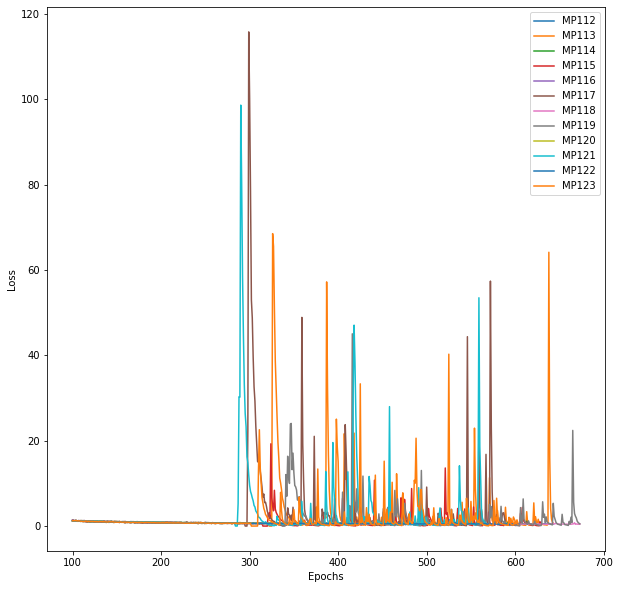

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]:
    ax.plot(exp.dynamics.model_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
pass

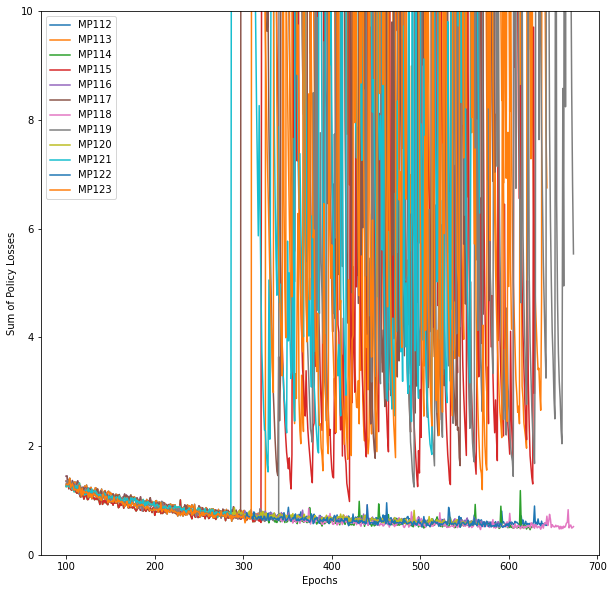

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]:
    ax.plot(exp.dynamics.model_pol_total_loss_history.mean(axis=1)[100:], label=exp.name)
ax.set_xlabel('Epochs')
ax.set_ylabel('Sum of Policy Losses')
ax.set_ylim(0,10)
ax.legend()
pass

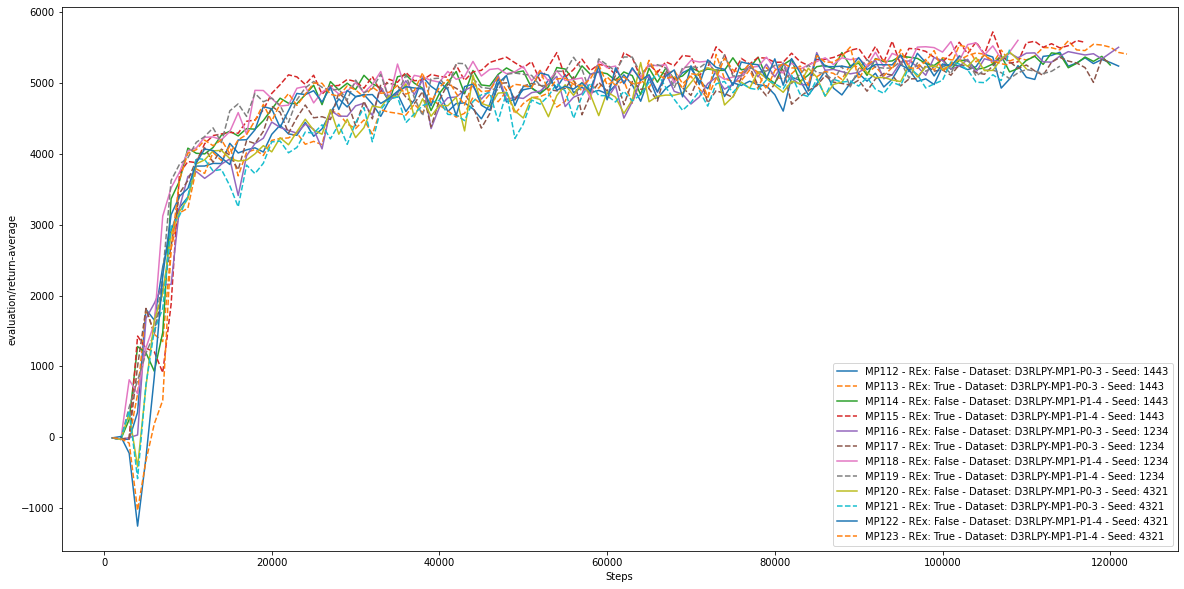

In [191]:
feature = 'evaluation/return-average'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

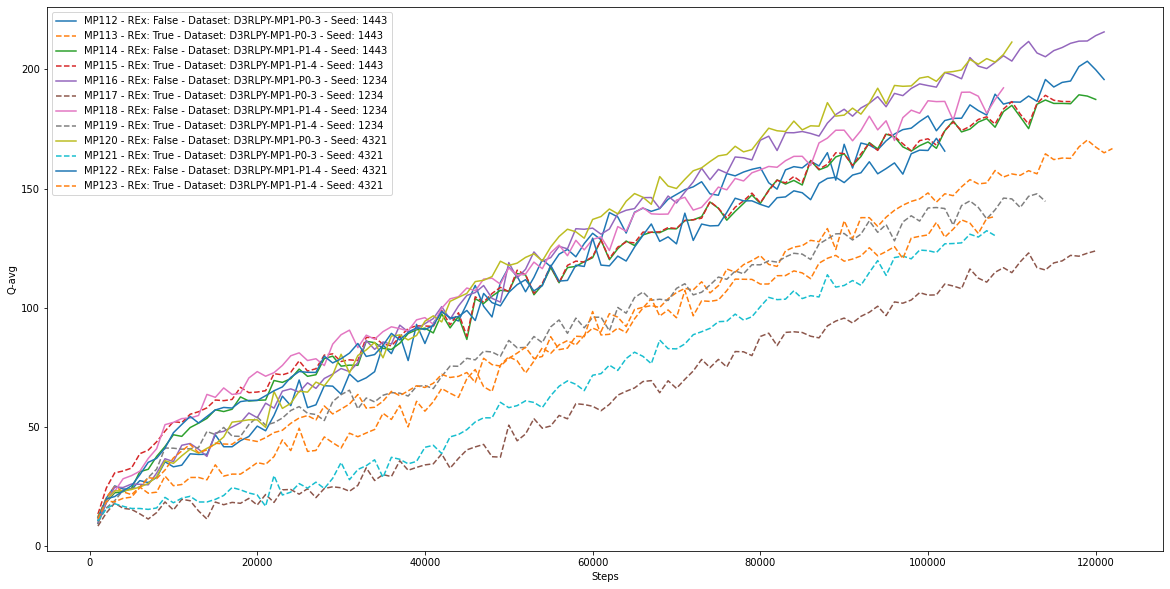

In [192]:
feature = 'Q-avg'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass

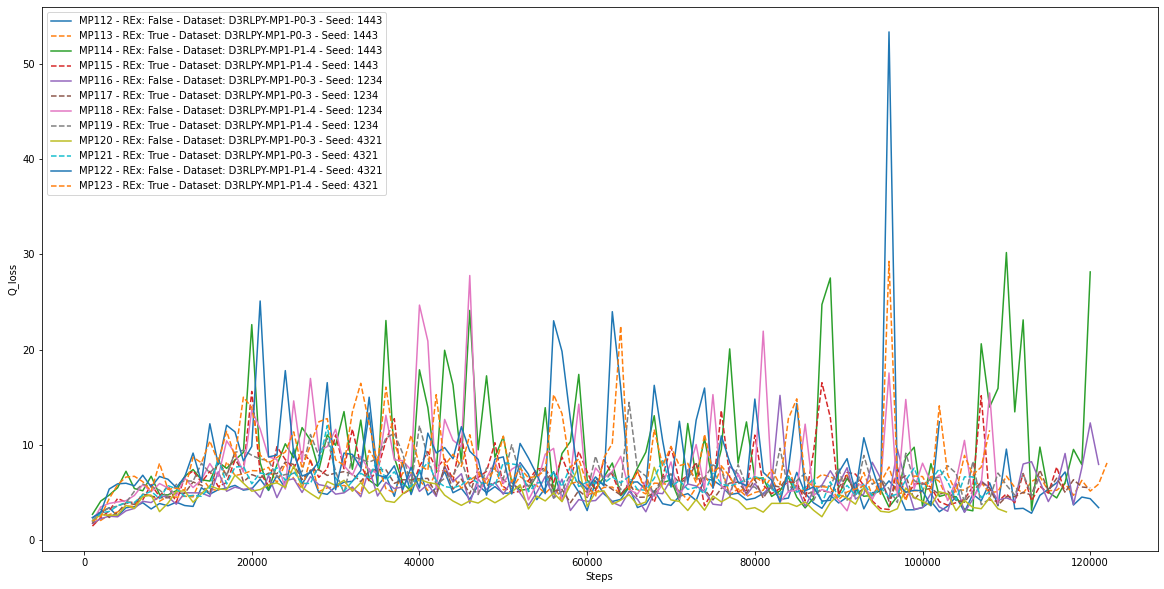

In [193]:
feature = 'Q_loss'
fig, ax = plt.subplots(1, 1, figsize=(20,10))
for exp in [
    MP112,
    MP113,
    MP114,
    MP115,
    MP116,
    MP117,
    MP118,
    MP119,
    MP120,
    MP121,
    MP122,
    MP123,
]:
    ax.plot(
        exp.sac.result['timesteps_total'], exp.sac.result[feature], label=f'{exp.name} - REx: {exp.rex} - Dataset: {exp.dataset} - Seed: {exp.seed}', ls='--' if exp.rex else '-'
    )
ax.set_xlabel('Steps')
ax.set_ylabel(feature)
ax.legend()
pass